# Airbus Impact Project

## Table of contents

1. [Imports](#1-imports)
    - [Import Datasets](#10-import-datasets)
2. [EDA](#define-date-and-time-columns)
3. [New Features](#new-features)

___
## 1. Imports

In [1]:
# Imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import quantile, where, random
import datetime
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt, dates
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 1.0 Import Datasets

In [2]:
filenames = ["data/msn_02_fuel_leak_signals_preprocessed.csv", 
             "data/msn_10_fuel_leak_signals_preprocessed.csv", 
             "data/msn_11_fuel_leak_signals_preprocessed.csv", 
             "data/msn_12_fuel_leak_signals_preprocessed.csv", 
             "data/msn_14_fuel_leak_signals_preprocessed.csv", 
             "data/msn_29_fuel_leak_signals_preprocessed.csv", 
             "data/msn_37_fuel_leak_signals_preprocessed.csv", 
             "data/msn_53_fuel_leak_signals_preprocessed.csv"]

datasets = []
datasets_labels = ["MSN_02", "MSN_10", "MSN_11", "MSN_12", "MSN_14", "MSN_29", "MSN_37", "MSN_53", "MSN_37_LEAK0.5", "MSN_37_LEAK1.0", "MSN_37_LEAK5.0"]
                   
for filename in filenames:
    datasets.append(pd.read_csv(filename, sep=";"))
    
# Copy datasets for leak simulation and add to datasets list
for i in range(3):
    datasets.append(datasets[6].copy())
    
print("Datasets loaded")

Datasets loaded


### 1.1 Define Date and Time Columns

In [3]:
for dataset in datasets:
    #introduce column date
    dataset['UTC_TIME'] = pd.to_datetime(dataset['UTC_TIME'])
    dataset['DATE'] = dataset['UTC_TIME'].dt.date
    dataset["TIME"] = dataset['UTC_TIME'].dt.time

### 1.2 Define MSN for every dataset with the labels

In [4]:
# for every dataset in datasets assign the label to MSN
for i in range(len(datasets)):
    datasets[i]["MSN"] = datasets_labels[i]

___
## 2. Data Exploration

### 2.0 Check for Records and Features for every dataset

In [5]:
data = {}

data['Records'] = [dataset.shape[0] for dataset in datasets]
data['Features'] = [dataset.shape[1] for dataset in datasets]

pd.DataFrame(data, index = datasets_labels)

Records  Features
MSN_02           623580       113
MSN_10           621610        19
MSN_11          4455992        19
MSN_12          3247664        19
MSN_14          4640993        19
MSN_29          4129447        19
MSN_37          3236645        19
MSN_53          3034227        19
MSN_37_LEAK0.5  3236645        19
MSN_37_LEAK1.0  3236645        19
MSN_37_LEAK5.0  3236645        19

### 2.1 Display columns in all datasets

In [6]:
for dataset in datasets:
    print(dataset.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623580 entries, 0 to 623579
Data columns (total 113 columns):
 #    Column                                Dtype         
---   ------                                -----         
 0    UTC_TIME                              datetime64[ns]
 1    MSN                                   object        
 2    Flight                                object        
 3    ENGINE_RUNNING_1                      bool          
 4    ENGINE_RUNNING_2                      bool          
 5    ENGINE_RUNNING_3                      bool          
 6    ENGINE_RUNNING_4                      bool          
 7    FLIGHT_PHASE_COUNT                    float64       
 8    FUEL_FLOW_1                           float64       
 9    FUEL_FLOW_2                           float64       
 10   FUEL_FLOW_3                           float64       
 11   FUEL_FLOW_4                           float64       
 12   FUEL_PITCH                            float64       
 13

Print Total Null values and relative Null values

In [7]:
pd.DataFrame({'NULL_VALUES': datasets[0].isnull().sum(), 'NULL_VALUES_%': datasets[0].isnull().sum() / datasets[0].shape[0] * 100, 'UNIQUE VALUES': datasets[0].nunique()})

NULL_VALUES  NULL_VALUES_%  UNIQUE VALUES
UTC_TIME                       0       0.000000         610106
MSN                            0       0.000000              1
Flight                         0       0.000000             42
ENGINE_RUNNING_1               0       0.000000              2
ENGINE_RUNNING_2               0       0.000000              2
...                          ...            ...            ...
STATUS_OVERFLOW_RST        63293      10.149941              1
VALUE_FUEL_VOL_LST         63265      10.145450         231657
VALUE_FUEL_VOL_RST         63275      10.147054           1636
DATE                           0       0.000000             36
TIME                           0       0.000000          66578

[113 rows x 3 columns]

In [8]:
# Do the same for all datasets
df_feat = pd.DataFrame()

for i in range(1, len(datasets)):
    df_tmp = pd.DataFrame({f'{datasets_labels[i]}_miss': datasets[i].isnull().sum(), 
                           f'{datasets_labels[i]}_miss_%': datasets[i].isnull().sum() / datasets[i].shape[0] * 100, 
                           f'{datasets_labels[i]}_unique': datasets[i].nunique()})
    df_feat = pd.concat([df_feat, df_tmp], axis=1)
    
df_feat

MSN_10_miss  MSN_10_miss_%  MSN_10_unique  MSN_11_miss  \
UTC_TIME                      0       0.000000         621610            0   
FUEL_USED_2              562272      90.454143            167      4131081   
FUEL_USED_3              560674      90.197069             46      4139824   
FUEL_USED_4              565835      91.027332            280      4164851   
FW_GEO_ALTITUDE           82937      13.342289          34301       300327   
VALUE_FOB                 82937      13.342289          40071       300327   
VALUE_FUEL_QTY_CT         82937      13.342289          10980       300327   
VALUE_FUEL_QTY_FT1        82937      13.342289           1007       300327   
VALUE_FUEL_QTY_FT2        82937      13.342289           1366       300327   
VALUE_FUEL_QTY_FT3        82937      13.342289           1162       300327   
VALUE_FUEL_QTY_FT4        82937      13.342289            994       300327   
VALUE_FUEL_QTY_LXT        82937      13.342289          12884       300327   
VALUE_FUEL_QTY_RXT        82937      13.342289          12803       300327   
FLIGHT_PHASE_COUNT        82364      13.250109             13       300201   
FUEL_USED_1              569171      91.564003             44      4126336   
Flight                        0       0.000000            540            0   
MSN                           0       0.000000              1            0   
DATE                          0       0.000000            114            0   
TIME                          0       0.000000          86400            0   

                    MSN_11_miss_%  MSN_11_unique  MSN_12_miss  MSN_12_miss_%  \
UTC_TIME                 0.000000        4455992            0       0.000000   
FUEL_USED_2             92.708447          79193      3123512      96.177191   
FUEL_USED_3             92.904655          74411      3124135      96.196374   
FUEL_USED_4             93.466303          61768      3124839      96.218051   
FW_GEO_ALTITUDE          6.739846          36757        40360       1.242739   
VALUE_FOB                6.739846          51763        40170       1.236889   
VALUE_FUEL_QTY_CT        6.739846          11490        40170       1.236889   
VALUE_FUEL_QTY_FT1       6.739846           1805        40170       1.236889   
VALUE_FUEL_QTY_FT2       6.739846           2238        40170       1.236889   
VALUE_FUEL_QTY_FT3       6.739846           2201        40170       1.236889   
VALUE_FUEL_QTY_FT4       6.739846           1954        40170       1.236889   
VALUE_FUEL_QTY_LXT       6.739846          13565        40170       1.236889   
VALUE_FUEL_QTY_RXT       6.739846          13431        40170       1.236889   
FLIGHT_PHASE_COUNT       6.737018             13        39807       1.225712   
FUEL_USED_1             92.601962          84070      3118944      96.036536   
Flight                   0.000000           2024            0       0.000000   
MSN                      0.000000              1            0       0.000000   
DATE                     0.000000            527            0       0.000000   
TIME                     0.000000          86400            0       0.000000   

                    MSN_12_unique  MSN_14_miss  MSN_14_miss_%  MSN_14_unique  \
UTC_TIME                  3247664            0       0.000000        4640993   
FUEL_USED_2                 76080      4372059      94.205249         183458   
FUEL_USED_3                 73428      4371649      94.196414         175370   
FUEL_USED_4                 67163      4374096      94.249140         160715   
FW_GEO_ALTITUDE             36710        65487       1.411056          36845   
VALUE_FOB                   43076        65487       1.411056          43874   
VALUE_FUEL_QTY_CT           11305        65487       1.411056          11550   
VALUE_FUEL_QTY_FT1           1425        65487       1.411056           1566   
VALUE_FUEL_QTY_FT2           1877        65487       1.411056           2266   
VALUE_FUEL_QTY_FT3           1939        65487       1.411

In [9]:
# print relative amount of flight phase 8
print("Relative amount of flight phases 3-11")
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].shape[0] / dataset.shape[0] * 100)
    
print("\nRelative amount of rows with NaN values in flight phases 3-11")
# count rows with NaN values in flight phases 3-11
for dataset in datasets:
    print(dataset[dataset['FLIGHT_PHASE_COUNT'].isin(list(range(3,12)))].isnull().any(axis=1).sum() / dataset.shape[0] * 100)


Relative amount of flight phases 3-11
70.66102184162418
76.78930519135793
83.32833631658225
87.78793003217082
88.45331160809766
82.0043458603537
87.88680871705114
88.84331989663265
87.88680871705114
87.88680871705114
87.88680871705114

Relative amount of rows with NaN values in flight phases 3-11
69.13691908015011
76.78930519135793
82.6928100409516
86.52459121386941
85.92697726542575
81.70161767423096
84.53345980173914
85.43022654534417
84.53345980173914
84.53345980173914
84.53345980173914


In [10]:
records_total = sum([dataset.shape[0] for dataset in datasets])
records_dropna = sum([dataset.dropna().shape[0] for dataset in datasets])

records_dropna_flightphase = {
    i: sum([dataset[dataset['FLIGHT_PHASE_COUNT'] == i].dropna().shape[0] for dataset in datasets])
    for i in range(1, 13)
}

print("Total records:", records_total)
print("Records after dropna:", records_dropna)
print("Records after dropna per flight phase:", records_dropna_flightphase)

Total records: 33700093
Records after dropna: 1664035
Records after dropna per flight phase: {1: 16973, 2: 897470, 3: 678, 4: 169, 5: 312, 6: 727, 7: 6479, 8: 670745, 9: 2677, 10: 241, 11: 64277, 12: 3287}


In [11]:
# Drop rows with duplicats in UTC_TIME
for dataset in datasets:
    dataset.drop_duplicates(subset=['UTC_TIME'], inplace=True)

In [12]:
df_tmp = pd.DataFrame(records_dropna_flightphase, index=['Records']).transpose()
 
fig = px.bar(df_tmp, x=df_tmp.index, y='Records', title='Records after dropna per flight phase')
fig.show()


### Calculate std of diff in tanks by flight-phase.

In [13]:
datasets_dropna = [df.dropna() for df in datasets]
all_datasets = pd.concat(datasets_dropna, ignore_index=True)

columns_to_describe = [
    'FUEL_USED_1', 
    'FUEL_USED_2', 
    'FUEL_USED_3', 
    'FUEL_USED_4', 
    'VALUE_FUEL_QTY_CT', 
    'VALUE_FUEL_QTY_RXT', 
    'VALUE_FUEL_QTY_LXT', 
    'VALUE_FUEL_QTY_FT1', 
    'VALUE_FUEL_QTY_FT2', 
    'VALUE_FUEL_QTY_FT3', 
    'VALUE_FUEL_QTY_FT4'
]

all_datasets_diff = all_datasets.groupby('FLIGHT_PHASE_COUNT')[columns_to_describe].diff().dropna()
std_df = all_datasets_diff[columns_to_describe].std().reset_index()
std_df

index           0
0          FUEL_USED_1  222.717422
1          FUEL_USED_2  221.589062
2          FUEL_USED_3  222.783578
3          FUEL_USED_4  223.892546
4    VALUE_FUEL_QTY_CT  201.931968
5   VALUE_FUEL_QTY_RXT  282.835625
6   VALUE_FUEL_QTY_LXT  284.436186
7   VALUE_FUEL_QTY_FT1   17.931267
8   VALUE_FUEL_QTY_FT2   23.882145
9   VALUE_FUEL_QTY_FT3   24.819852
10  VALUE_FUEL_QTY_FT4   19.429669

As can be seen in the examples above, flight phases two and eight are the ones that contain the most data. The fact that flight phase two describes the aircraft on the ground and that the parameters there could be falsified, for example, by refuelling or artificially resetting the fuel consumption, and the requirements of Airbus have prompted us to adopt only flight phase eight in our model.

___
# 3. Data Cleaning and Feature Engineering


### 3.0 Assign to each concetenated flight a unique flight number and only keep flight_phases 8

In the next cell we will divide the data into individual flight segments, which will be assigned unique numbers. This has the advantage that we can analyse individual sequences and describe them further in the EDA process. Before and after this, zero values are dropped.

We're keeping flight phase 8 as it has a lot of values that could be used for anomaly detection. 

We're cleaning the second flight_phase.

In [14]:
columns_where_to_drop_nan = datasets[2].columns

def introduce_flight_column(dataset, flight_number):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # Drop NaN values
    dataset_tmp = dataset_tmp.dropna(subset=columns_where_to_drop_nan)
    
    # assign flight number to rows that have indexes following each other
    # if the difference between two indexes is greater than 1, a new flight is assumed
    # print(dataset_tmp.shape)
    
    for i in range(1, dataset_tmp.shape[0]):
        if dataset_tmp.index[i] - dataset_tmp.index[i-1] > 1:
            flight_number += 1
        dataset_tmp.at[dataset_tmp.index[i], 'FLIGHT'] = flight_number
        
    # Fill nan values in flight column with 0
    dataset_tmp['FLIGHT'] = dataset_tmp['FLIGHT'].fillna(0)
    
    # only keep rows with flight_phase_count = 2 and 8
    dataset_tmp =  dataset_tmp[dataset_tmp['FLIGHT_PHASE_COUNT'].isin([8])]
            
    # return dataset with flight column
    return dataset_tmp, flight_number
   

In [15]:
flight_number = 0
datasets_unique_flights = []
 
for dataset in datasets_dropna:
    dataset_tmp, flight_number = introduce_flight_column(dataset, flight_number)
    datasets_unique_flights.append(dataset_tmp)

In [16]:
# for each dataset in datasets_unique_flights count occurences of FLIGHT
for dataset in datasets_unique_flights:
    counts = dataset['FLIGHT'].value_counts()
    try:
        print(pd.DataFrame(counts).sort_values(by='FLIGHT', ascending=False).iloc[0].FLIGHT)
    except:
        print("No flights found")

374
No flights found
736
1118
3312
366
1806
1873
1806
1806
1806


In [17]:
for dataset in datasets_unique_flights:
    print(dataset.shape)

(1846, 114)
(0, 20)
(23578, 20)
(37496, 20)
(111067, 20)
(11081, 20)
(97365, 20)
(95967, 20)
(97365, 20)
(97365, 20)
(97365, 20)


### 3.0 Add synthetic Fuel Leak to different datasets

In [18]:
def create_leak(dataset, leak_flow, start_index=None, end_index=None, leak=True):
    # create copy of dataset    
    dataset_tmp = dataset.copy()
    
    # define FUEL_TANK_COLS 
    FUEL_TANK_COLS = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    # choose random fuel tank where the fuel leak is happening
    while True:
        fuel_tank = random.choice(FUEL_TANK_COLS)
     
        # check if fuel tank is empty at any point in time
        if dataset_tmp[fuel_tank].max() >= leak_flow:
            break
    
    if leak == False:
        # substract the same amount of fuel from value_fob
        dataset_tmp['VALUE_FOB'] = dataset_tmp['VALUE_FOB'] - leak_flow
    else:
        increment = 0
        #for index in dataset_tmp.index:
         #   dataset_tmp.at[index, 'VALUE_FOB'] -= leak_flow + increment
          #  increment += leak_flow
        # substract leak flow from fuel tank per sequence in FLIGHT
        for flight in dataset_tmp['FLIGHT'].unique():
            # from value_fob substract leak flow. Leak flow should be increased by leak flow per row
            increment = 0
            for index in dataset_tmp[dataset_tmp["FLIGHT"] == flight].index:
                dataset_tmp.at[index, 'VALUE_FOB'] -= leak_flow + increment
                dataset_tmp.at[index, fuel_tank] -= leak_flow + increment
                increment += leak_flow
    
    # set negative values in value_fob to 0 
    dataset_tmp['VALUE_FOB'] = dataset_tmp['VALUE_FOB'].clip(lower=0)
    
    # set negative values in fuel_tank to 0 
    dataset_tmp[fuel_tank] = dataset_tmp[fuel_tank].clip(lower=0)

    return dataset_tmp

In [19]:
# from this point the following changes will be applied to two list of datasets
datasets_unique_flights_with_fuel_leak = datasets_unique_flights.copy()

# add fuel leak to the last 3 datasets. First one 0.5L per minute, second 1L per minute, third 5L per minute
datasets_unique_flights_with_fuel_leak[-1] = create_leak(datasets_unique_flights[-1], 5)
datasets_unique_flights_with_fuel_leak[-2] = create_leak(datasets_unique_flights[-2], 1)
datasets_unique_flights_with_fuel_leak[-3] = create_leak(datasets_unique_flights[-3], 0.5)

In [20]:
for dataset in datasets_unique_flights:
    print(dataset.shape)

(1846, 114)
(0, 20)
(23578, 20)
(37496, 20)
(111067, 20)
(11081, 20)
(97365, 20)
(95967, 20)
(97365, 20)
(97365, 20)
(97365, 20)


As we don't have a single value in Dataset 2 we gonna drop it at this point

In [21]:
# Drop second dataset from datasets_unique_flights
datasets_unique_flights.pop(1)
datasets_unique_flights_with_fuel_leak.pop(1)

Empty DataFrame
Columns: [UTC_TIME, FUEL_USED_2, FUEL_USED_3, FUEL_USED_4, FW_GEO_ALTITUDE, VALUE_FOB, VALUE_FUEL_QTY_CT, VALUE_FUEL_QTY_FT1, VALUE_FUEL_QTY_FT2, VALUE_FUEL_QTY_FT3, VALUE_FUEL_QTY_FT4, VALUE_FUEL_QTY_LXT, VALUE_FUEL_QTY_RXT, FLIGHT_PHASE_COUNT, FUEL_USED_1, Flight, MSN, DATE, TIME, FLIGHT]
Index: []

### 3.2 New Features

In [22]:
# helper function to subtract first value of a series from all values
def subtract_first(x):
    return x.iloc[0] - x

def define_new_features(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
    
    # initialize TOTAL_FUEK_USED column
    dataset_tmp['TOTAL_FUEL_USED'] = 0
     
    # Total fuel column is the sum of all fuel used columns
    for i in range(1, 5):
        dataset_tmp['TOTAL_FUEL_USED'] += dataset_tmp['FUEL_USED_' + str(i)]
        
    # Get difference for VALUE_FOB for each flight 
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].diff()
    dataset_tmp['VALUE_FOB_DIFF'] = dataset_tmp['VALUE_FOB_DIFF'].fillna(0)
    
    dataset_tmp['TOTAL_FOB_BY_QTY'] = dataset_tmp['VALUE_FUEL_QTY_CT'] + dataset_tmp['VALUE_FUEL_QTY_FT1'] + dataset_tmp['VALUE_FUEL_QTY_FT2'] + dataset_tmp['VALUE_FUEL_QTY_FT3'] + dataset_tmp['VALUE_FUEL_QTY_FT4'] + dataset_tmp['VALUE_FUEL_QTY_LXT'] + dataset_tmp['VALUE_FUEL_QTY_RXT']
    
    dataset_tmp['DELTA_VFOB_VS_VFOBQTY'] = dataset_tmp['VALUE_FOB'] - dataset_tmp['TOTAL_FOB_BY_QTY']
    
    dataset_tmp['ALTITUDE_DIFF'] = dataset_tmp['FW_GEO_ALTITUDE'].diff().abs() 
    
    dataset_tmp['VALUE_FOB_MISSING'] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)  
    
    dataset_tmp['VALUE_FOB_MISSING_BY_QTY'] = dataset_tmp.groupby('FLIGHT')['TOTAL_FOB_BY_QTY'].transform(subtract_first)
    
    # new columnn VALUE_FOB_BY_FUEL_USED. 
    #For ex: FOB_calculated(t=3) = VALUE_FOB(t=0) - delta_total_fuel_used(t=1) - delta_total_fuel_used(t=2) - delta_total_fuel_used(t=3)
    for flight in dataset_tmp['FLIGHT'].unique():
        value_fob_0 = dataset_tmp[dataset_tmp['FLIGHT'] == flight]['VALUE_FOB'].iloc[0]
        # column VALUE_FOB_BY_FUEL_USED is value_fob_0 - TOTAL_FUEL_USED
        dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'VALUE_FOB_BY_FUEL_USED'] = value_fob_0 - dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'TOTAL_FUEL_USED']
        
    # code to remove first part of flight where the plane is on the ground and the fuel used is resetted
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True) 
    
    # for each FLIGHT substract the first value of TOTAL_FUEL_USED from all values
    #for flight in dataset_tmp['FLIGHT'].unique():
    #    dataset_tmp.loc[dataset_tmp['FLIGHT'] == flight, 'TOTAL_FUEL_USED'] -= dataset_tmp[dataset_tmp['FLIGHT'] == flight]['TOTAL_FUEL_USED'].iloc[0]
    
    return dataset_tmp

In [23]:
datasets_with_new_features = [define_new_features(dataset) for dataset in datasets_unique_flights]
datasets_with_new_features_with_fuel_leak = [define_new_features(dataset) for dataset in datasets_unique_flights_with_fuel_leak]

In [24]:
# Print shape of datasets to see total number of features
for dataset in datasets_with_new_features:
    print(dataset.shape)

(1839, 122)
(23440, 28)
(37316, 28)
(110573, 28)
(11018, 28)
(96849, 28)
(95498, 28)
(96849, 28)
(96849, 28)
(96849, 28)


### 3.3 Deleting Values before all Fuel_Used Columns are resetted 
Not necassary if only flight phase 8 is used

In [25]:
def initalize_flights(dataset):
    # copy dataset
    dataset_tmp = dataset.copy()
     
    for flight_num in dataset_tmp['FLIGHT'].unique():
        # get first index of flight 
        first_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[0]
        
        # get last index of flight
        last_index = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num].index[-1]
        
        # get location of min value of VALUE_FOB per flight 
        min_value_sum_fuel_used = dataset_tmp[dataset_tmp['FLIGHT'] == flight_num]['TOTAL_FUEL_USED'].idxmin()
        
        # delete in dataset_tmp all rows between first_location and min_value_fob
        dataset_tmp.drop(dataset_tmp.loc[first_index:min_value_sum_fuel_used].index, inplace=True)
        
        # dataset_tmp["VALUE_FOB_MISSING"] = dataset_tmp.groupby('FLIGHT')['VALUE_FOB'].transform(subtract_first)
        
    return dataset_tmp

In [26]:
# Not necassary if only flight phase 8 is used
# datasets_without_reset_engines = [initalize_flights(dataset) for dataset in datasets_with_new_features]

In [27]:
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (1839, 122)
Dataset 0 unique flights: 7
Dataset 1 shape: (23440, 28)
Dataset 1 unique flights: 137
Dataset 2 shape: (37316, 28)
Dataset 2 unique flights: 180
Dataset 3 shape: (110573, 28)
Dataset 3 unique flights: 494
Dataset 4 shape: (11018, 28)
Dataset 4 unique flights: 63
Dataset 5 shape: (96849, 28)
Dataset 5 unique flights: 516
Dataset 6 shape: (95498, 28)
Dataset 6 unique flights: 469
Dataset 7 shape: (96849, 28)
Dataset 7 unique flights: 516
Dataset 8 shape: (96849, 28)
Dataset 8 unique flights: 516
Dataset 9 shape: (96849, 28)
Dataset 9 unique flights: 516


Plot Altitude vs Value Fob for dataset 0

Plot Altitude vs Value Fob for the rest of the datasets

In [28]:
flight_phase_dict = {
    1: 'Pre-flight',
    2: 'Engine Run',
    3: 'Take-Off 1',
    4: 'Take-Off 2',
    5: 'Take-Off 3',
    6: 'Climbing 1',
    7: 'Climbing 2',
    8: 'Cruise',
    9: 'Descent',
    10: 'Approach',
    11: 'Landing',
    12: 'Post-flight'
}

def plot_flight(dataset, min_flight_length=100, max_graphs=10):
    for flight_num in dataset["FLIGHT"].unique(): 
        fig = go.Figure()

        # Define data for flight
        flight_data = dataset[dataset['FLIGHT'] == flight_num]
        
        if flight_data.shape[0] < min_flight_length:
            continue
        
        # Define traces
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['VALUE_FOB'],
                                mode='lines',
                                name='VALUE_FOB')) 

        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                y=flight_data['FW_GEO_ALTITUDE'],
                                mode='lines',
                                name='FW_GEO_ALTITUDE'))
        
        # add trace for total_fuel_used
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['TOTAL_FUEL_USED'],
                                    mode='lines',
                                    name='TOTAL_FUEL_USED'))
        
        # add trace for VALUE_FOB_DIFF
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_DIFF'],
                                    mode='lines',
                                    name='VALUE_FOB_DIFF'))
        
        
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                    y=flight_data['VALUE_FOB_MISSING'],
                                    mode='lines',
                                    name='VALUE_FOB_MISSING'))
        
        fig.add_trace(go.Scatter(x=flight_data['UTC_TIME'],
                                 y=flight_data['VALUE_FOB_BY_FUEL_USED'],
                                 mode='lines',
                                 name='VALUE_FOB_BY_FUEL_USED'))
        
        
        for flight_phase in flight_data['FLIGHT_PHASE_COUNT'].unique():
            fig.add_trace(go.Scatter(x=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['UTC_TIME'],
                                    y=flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]['VALUE_FOB'],
                                    mode='lines',
                                        name=f'{flight_phase}, {flight_phase_dict[flight_phase]}'))

        fig.update_layout(title=f'VALUE_FOB and FW_GEO_ALTITUDE for flight {flight_num}',
                        xaxis_title='UTC_TIME',
                        yaxis_title='VALUE_FOB and FW_GEO_ALTITUDE')
        
        # Define rectangles for different flight phases
        shapes = []
        colors = [
        'LightSkyBlue', 'LightSalmon', 'LightGreen', 'LightYellow', 'LightPink', 
        'MediumPurple', 'DarkOrange', 'MediumSeaGreen', 'DeepSkyBlue']
        # Define more colors if needed
        for i, flight_phase in enumerate(flight_data['FLIGHT_PHASE_COUNT'].unique()):
            phase_data = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == flight_phase]
            shapes.append(
                go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",  # use 'paper' to refer to the entire y range
                    x0=phase_data['UTC_TIME'].min(),
                    x1=phase_data['UTC_TIME'].max(),
                    y0=0,
                    y1=1,
                    fillcolor=colors[i % len(colors)],
                    opacity=0.5,
                    layer="below",
                    line_width=0,
                )
            )
        
        fig.update_layout(shapes=shapes)
        fig.show()
        
        max_graphs -= 1
        
        if(max_graphs == 0):    
            break
        
        


In [29]:
plot_flight(datasets_with_new_features[-1], min_flight_length=500, max_graphs=5)

In [30]:
plot_flight(datasets_with_new_features_with_fuel_leak[-1], min_flight_length=500, max_graphs=5)

## Bring all datasets to the same shape

In [31]:
# Define functions to drop so that all datasets have the same columns
columns_to_drop = [column for column in datasets_with_new_features[0].columns if column not in datasets_with_new_features[2].columns]

datasets_with_new_features[0].drop(columns_to_drop, axis=1, inplace=True)
datasets_with_new_features_with_fuel_leak[0].drop(columns_to_drop, axis=1, inplace=True) 

In [32]:
# shape of datasets
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')

Dataset 0 shape: (1839, 28)
Dataset 0 unique flights: 7
Dataset 1 shape: (23440, 28)
Dataset 1 unique flights: 137
Dataset 2 shape: (37316, 28)
Dataset 2 unique flights: 180
Dataset 3 shape: (110573, 28)
Dataset 3 unique flights: 494
Dataset 4 shape: (11018, 28)
Dataset 4 unique flights: 63
Dataset 5 shape: (96849, 28)
Dataset 5 unique flights: 516
Dataset 6 shape: (95498, 28)
Dataset 6 unique flights: 469
Dataset 7 shape: (96849, 28)
Dataset 7 unique flights: 516
Dataset 8 shape: (96849, 28)
Dataset 8 unique flights: 516
Dataset 9 shape: (96849, 28)
Dataset 9 unique flights: 516


In [33]:
datasets_with_new_features[1]

UTC_TIME  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  \
2802286 2016-10-29 08:30:12    79.764977    73.332397    71.396461   
2802287 2016-10-29 08:30:13    79.862244    73.441658    71.505798   
2802288 2016-10-29 08:30:14    79.986839    73.550957    71.629326   
2802289 2016-10-29 08:30:15    80.097038    73.659943    71.753143   
2802290 2016-10-29 08:30:16    80.222511    73.782867    71.863022   
...                     ...          ...          ...          ...   
4433586 2018-01-12 11:38:34   629.968872   627.241943   620.253357   
4433587 2018-01-12 11:38:35   630.275879   627.587891   620.602661   
4433588 2018-01-12 11:38:36   630.622803   627.857178   620.911621   
4433589 2018-01-12 11:38:37   630.969971   628.204712   621.222778   
4433590 2018-01-12 11:38:38   631.008362   628.243591   621.261841   

         FW_GEO_ALTITUDE  VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  \
2802286           1840.0    24325.0                0.0              1819.0   
2802287           1890.0    24311.0                0.0              1821.0   
2802288           1935.0    24294.0                0.0              1821.0   
2802289           1972.0    24275.0                0.0              1820.0   
2802290           2008.0    24252.0                0.0              1819.0   
...                  ...        ...                ...                 ...   
4433586          28006.0    29254.0                4.0              1939.0   
4433587          28009.0    29250.0                3.0              1939.0   
4433588          28006.0    29248.0                3.0              1938.0   
4433589          28006.0    29245.0                3.0              1938.0   
4433590          28006.0    29243.0                3.0              1938.0   

         VALUE_FUEL_QTY_FT2  VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  \
2802286              2505.0              2439.0              1752.0   
2802287              2508.0              2436.0              1751.0   
2802288              2510.0              2432.0              1750.0   
2802289              2509.0              2429.0              1751.0   
2802290              2505.0              2427.0              1752.0   
...                     ...                 ...                 ...   
4433586              2556.0              2494.0              1916.0   
4433587              2556.0              2496.0              1916.0   
4433588              2556.0              2498.0              1916.0   
4433589              2556.0              2500.0              1915.0   
4433590              2555.0              2503.0              1915.0   

         VALUE_FUEL_QTY_LXT  VALUE_FUEL_QTY_RXT  FLIGHT_PHASE_COUNT  \
2802286              7897.0              7915.0                 8.0   
2802287              7896.0              7912.0                 8.0   
2802288              7892.0              7900.0                 8.0   
2802289              7892.0              7886.0                 8.0   
2802290              7884.0              7877.0                 8.0   
...                     ...                 ...                 ...   
4433586             10252.0             10095.0                 8.0   
4433587             10250.0             10092.0                 8.0   
4433588             10250.0             10089.0                 8.0   
4433589             10249.0             10086.0                 8.0   
4433590             10249.0             10083.0                 8.0   

         FUEL_USED_1  Flight     MSN        DATE      TIME  FLIGHT  \
2802286    78.558754  1772.0  MSN_11  2016-10-29  08:30:12    51.0   
2802287    78.666725  1772.0  MSN_11  2016-10-29  08:30:13    51.0   
2802288    78.788261  1772.0  MSN_11  2016-10-29  08:30:14    51.0   
2802289    78.910080  1772.0  MSN_11  2016-10-29  08:30:15    51.0   
2802290    79.004555  1772.0  MSN_11  2016-10-29  08:30:16    51.0   
...              ...     ...     ...         ...       ...     ...   
4433586   635.315186  2022.0  MSN_11  2018-01

Dataset 0 shape: (1839, 28)
Dataset 0 unique flights: 7


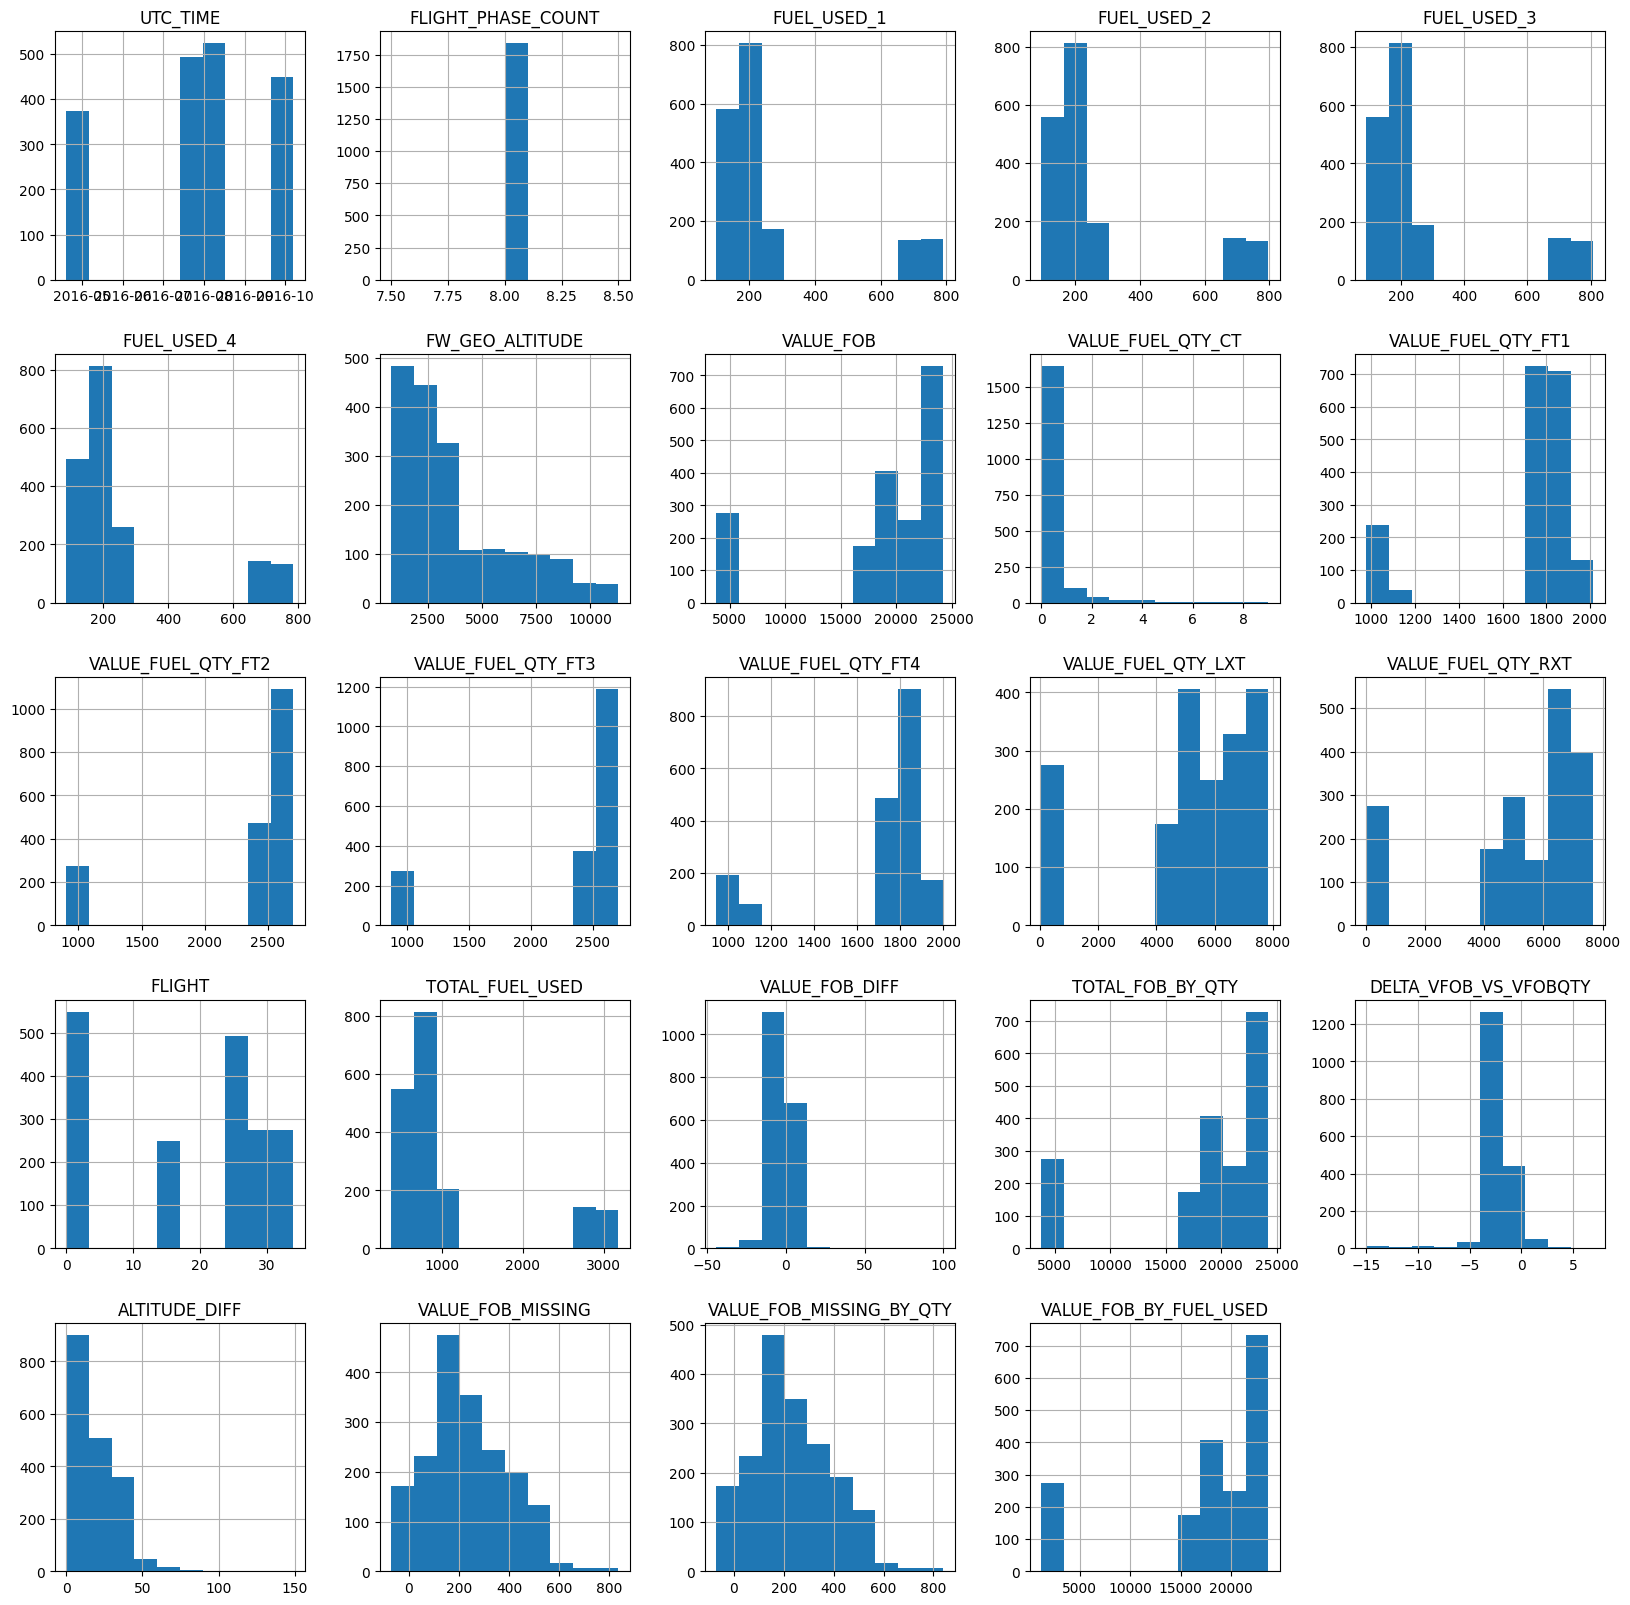

Dataset 1 shape: (23440, 28)
Dataset 1 unique flights: 137


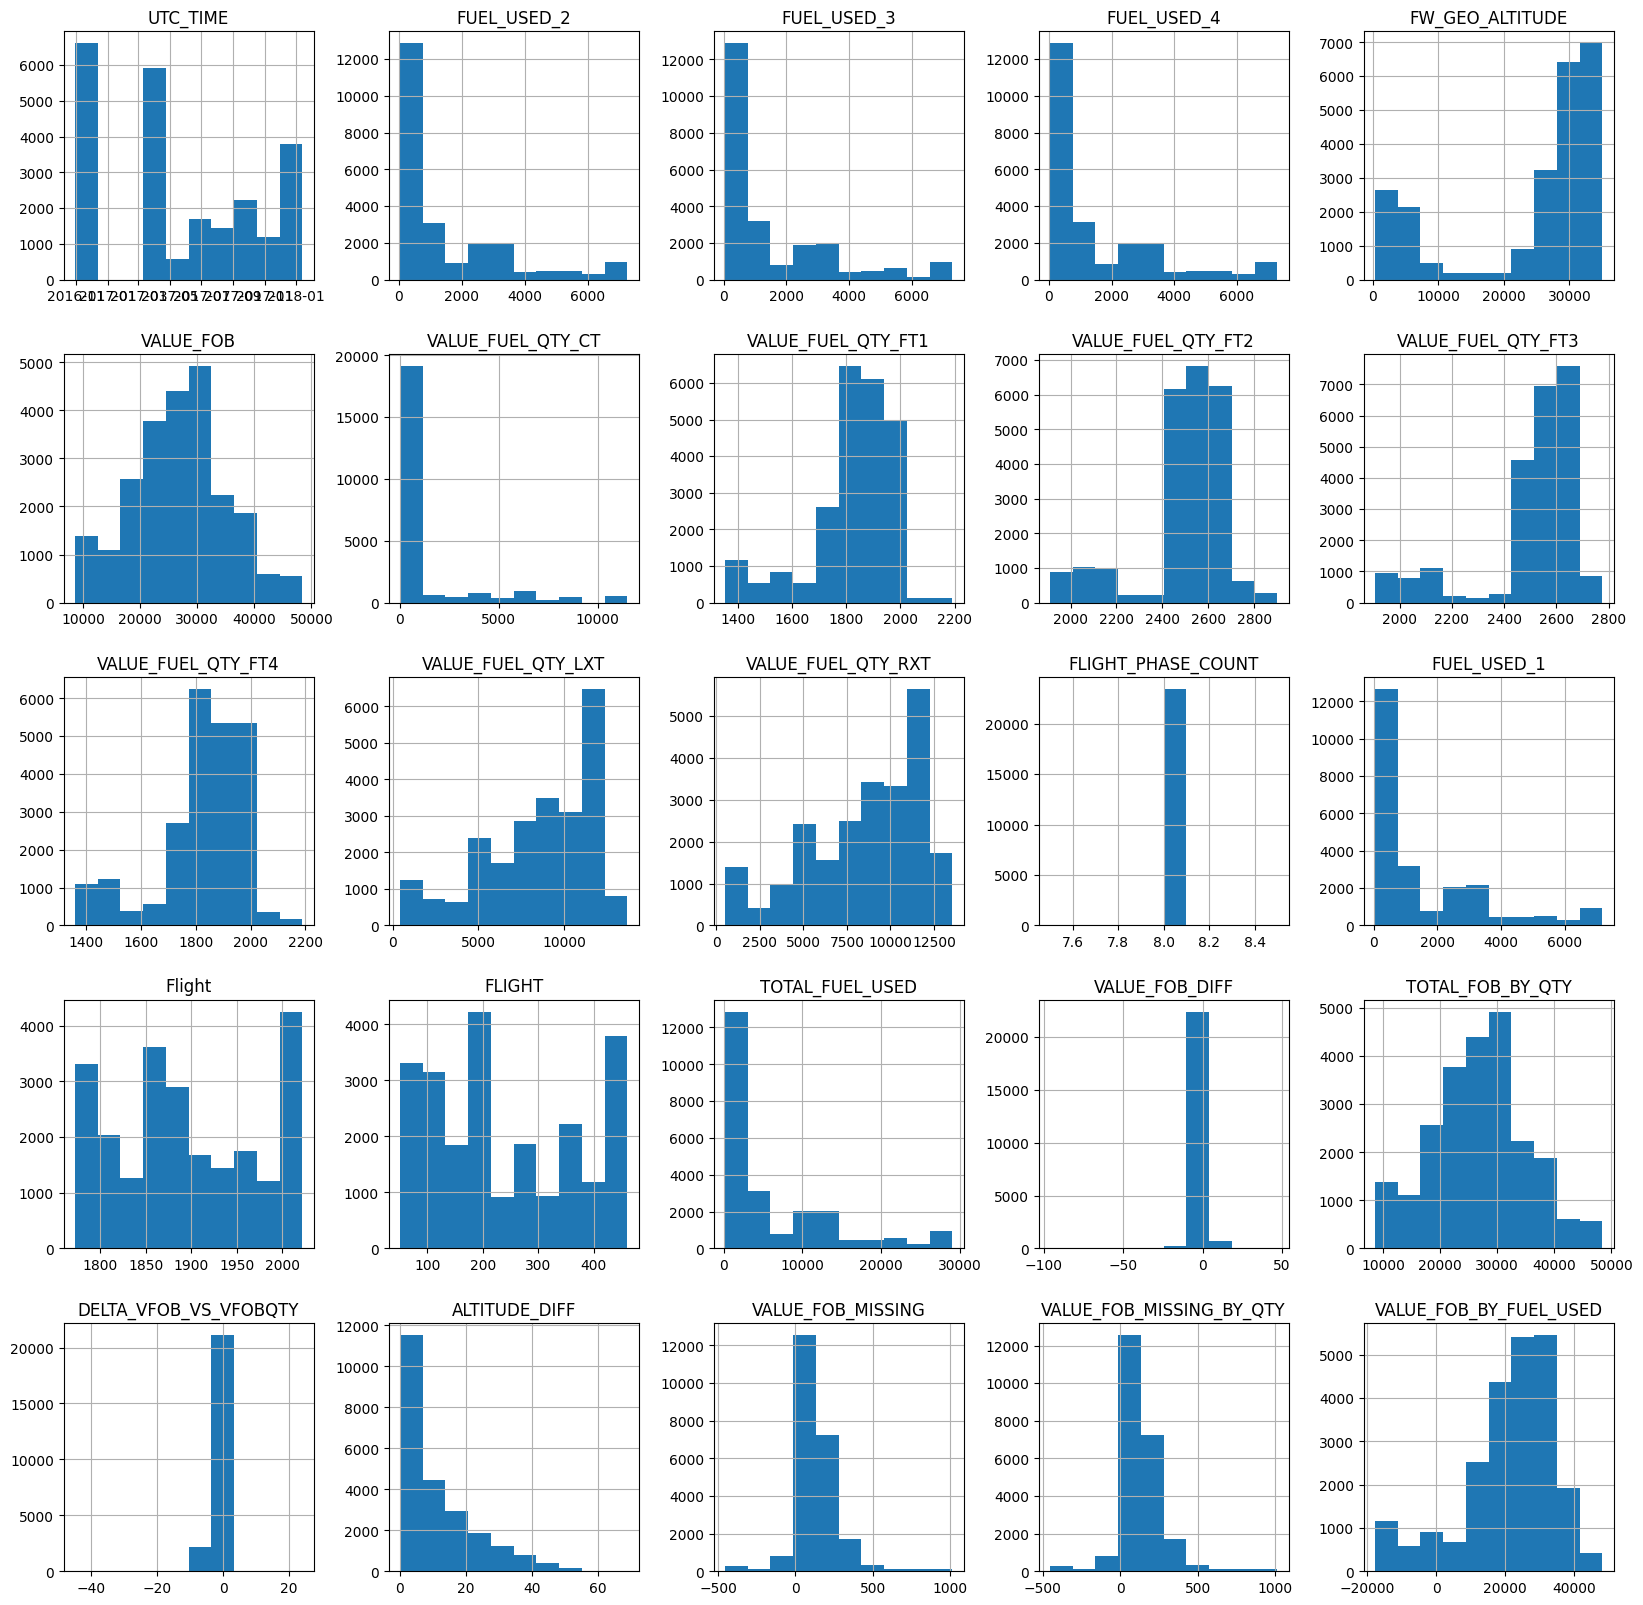

Dataset 2 shape: (37316, 28)
Dataset 2 unique flights: 180


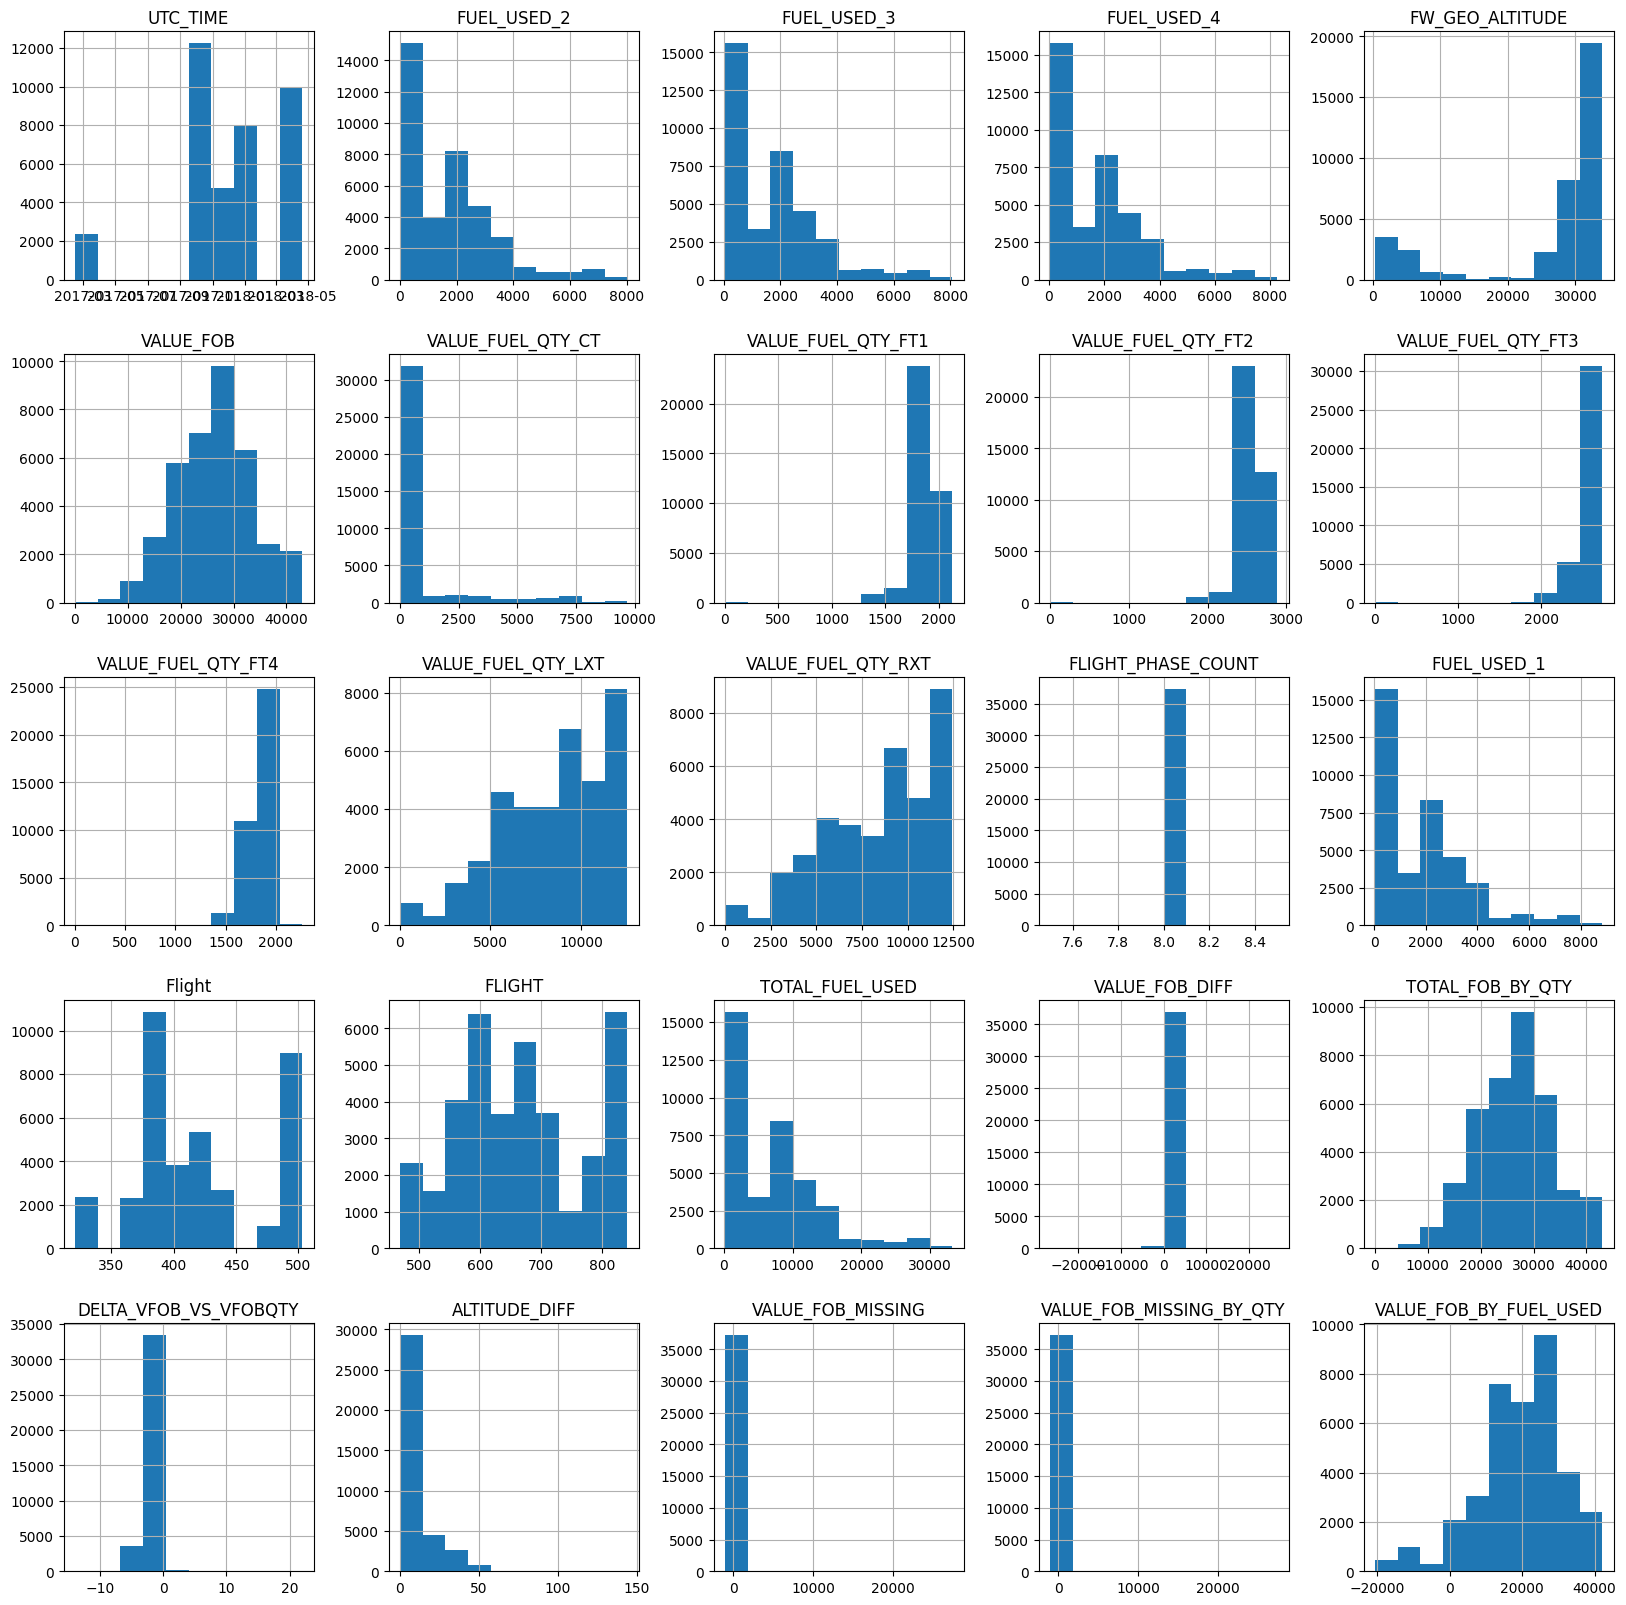

Dataset 3 shape: (110573, 28)
Dataset 3 unique flights: 494


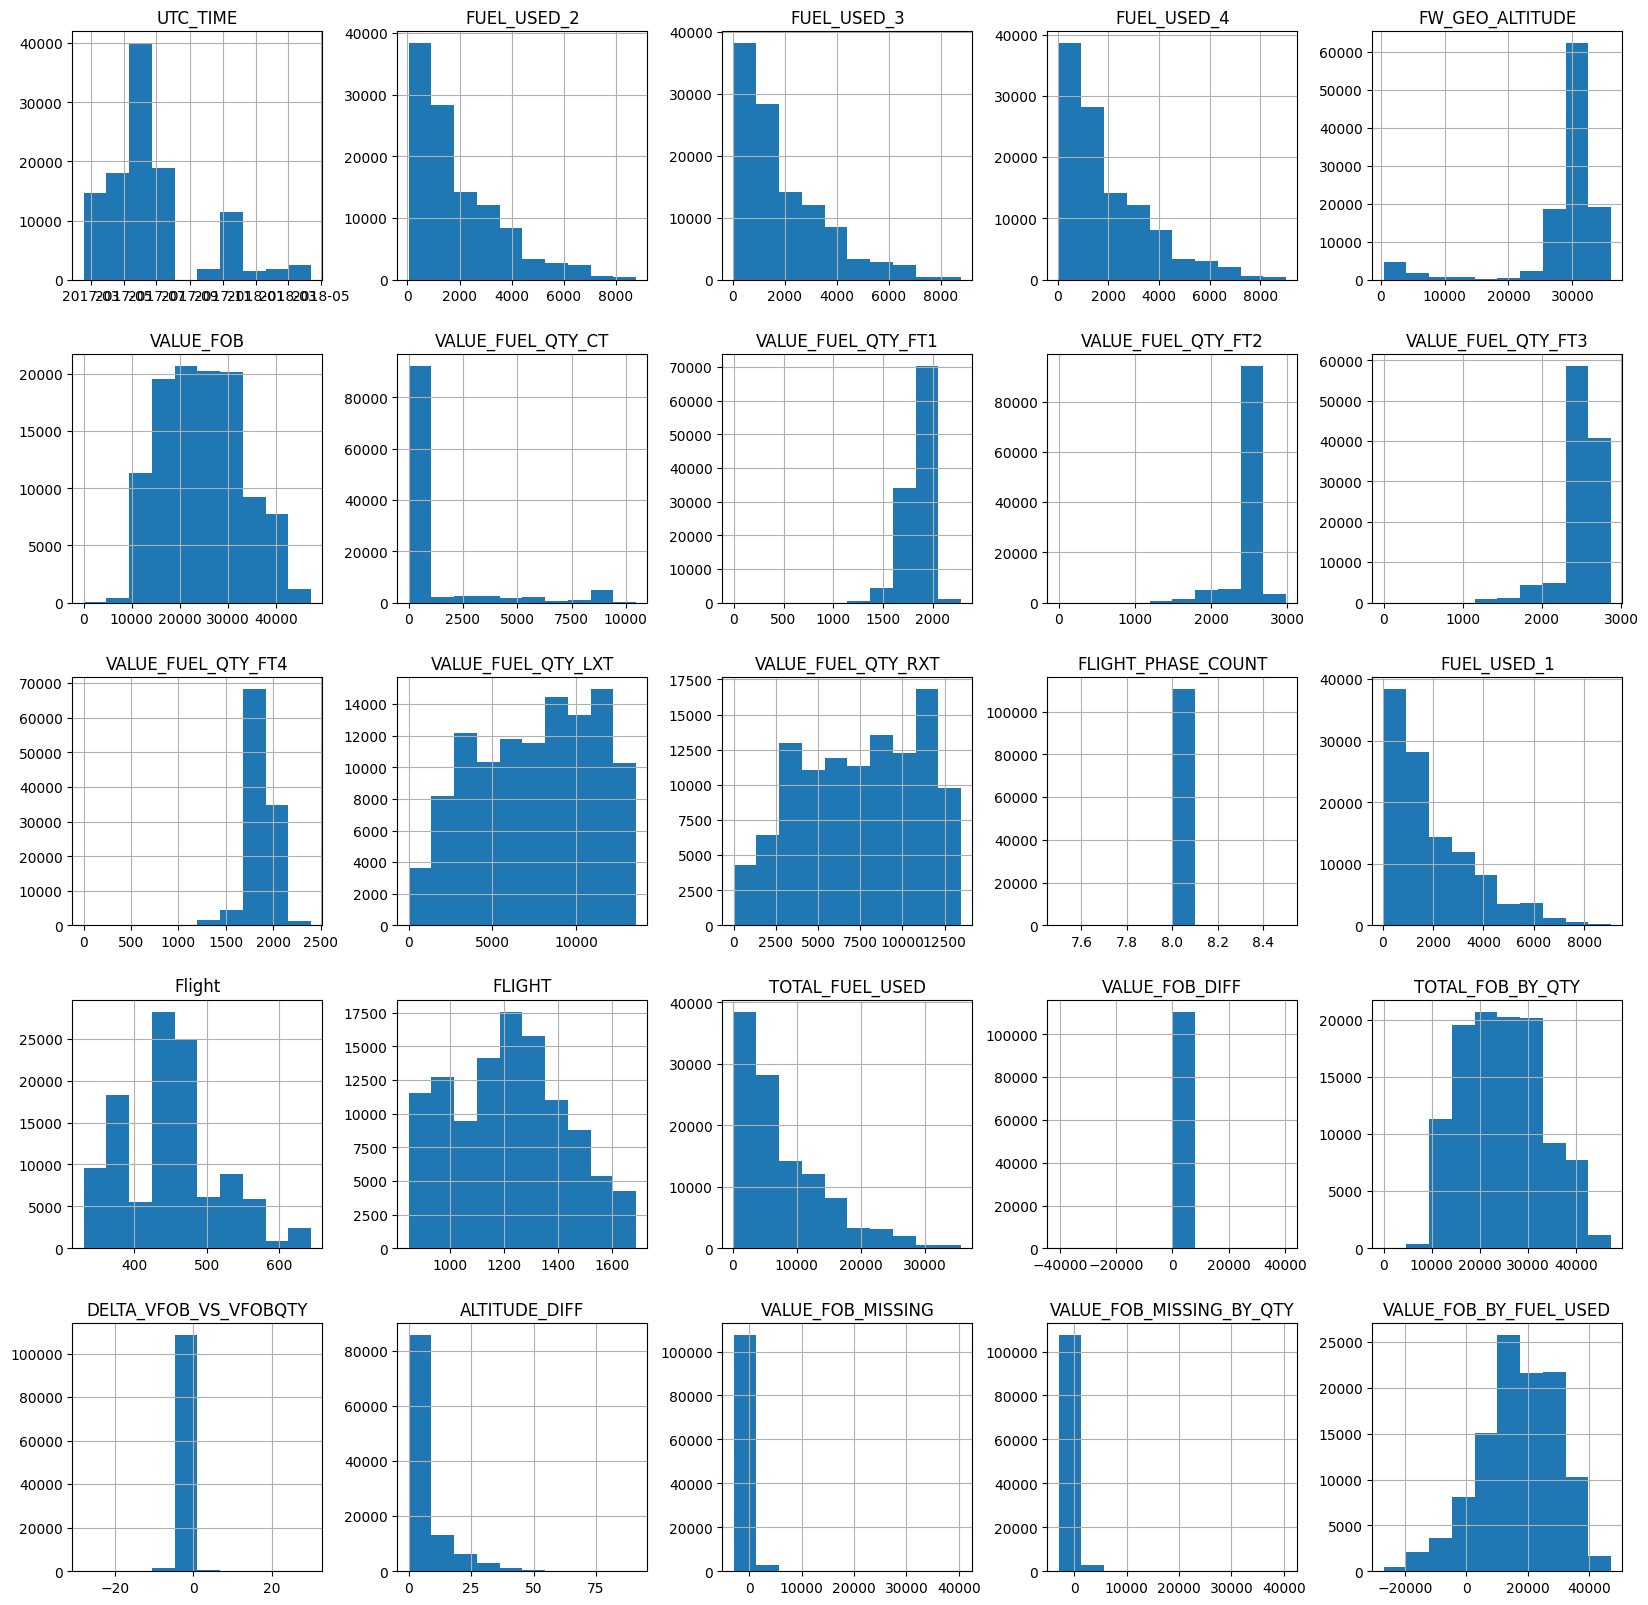

Dataset 4 shape: (11018, 28)
Dataset 4 unique flights: 63


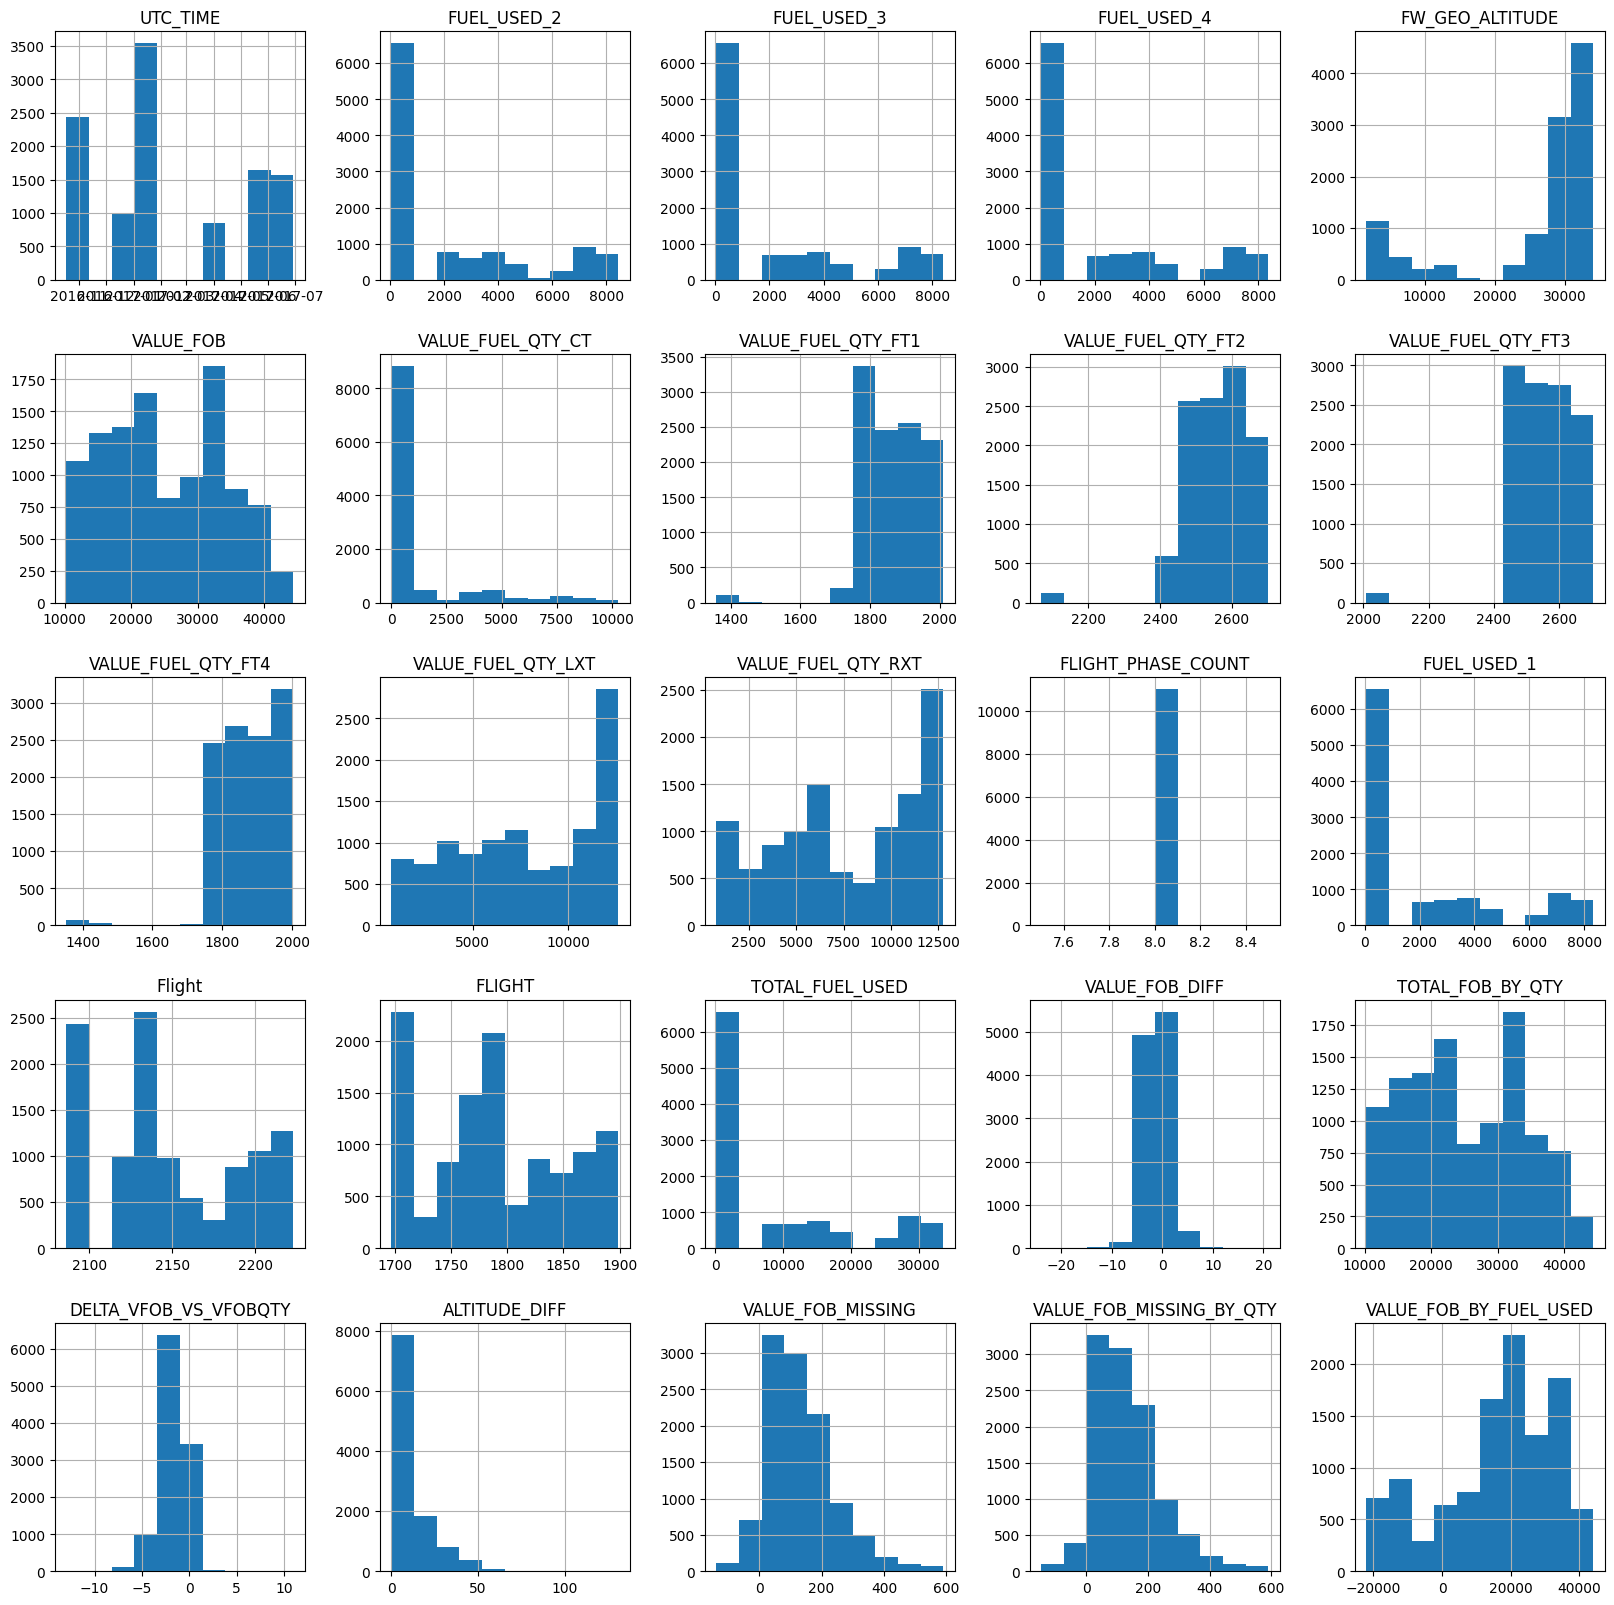

Dataset 5 shape: (96849, 28)
Dataset 5 unique flights: 516


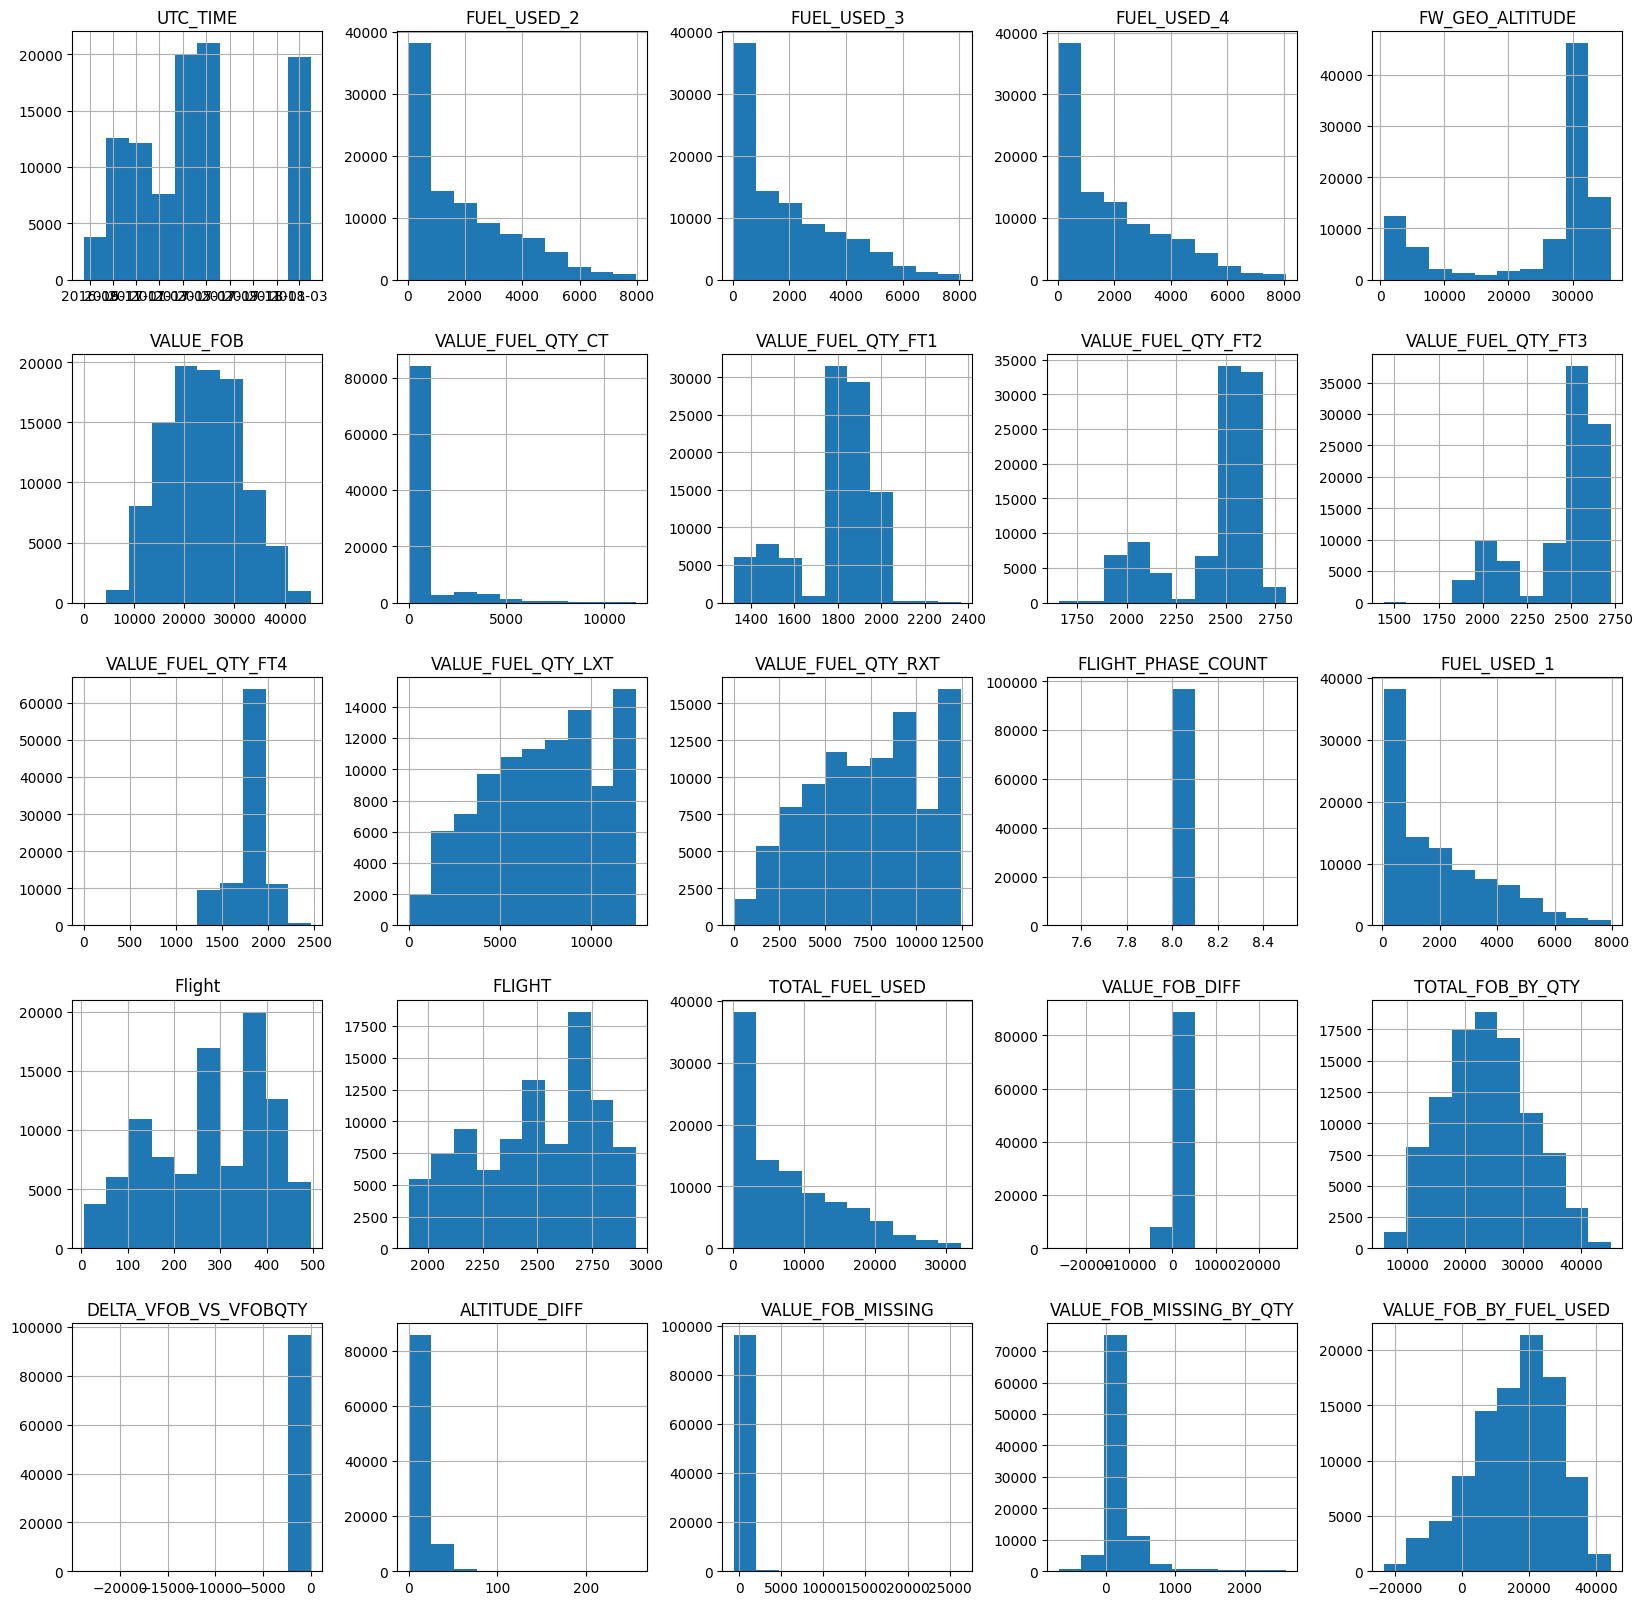

Dataset 6 shape: (95498, 28)
Dataset 6 unique flights: 469


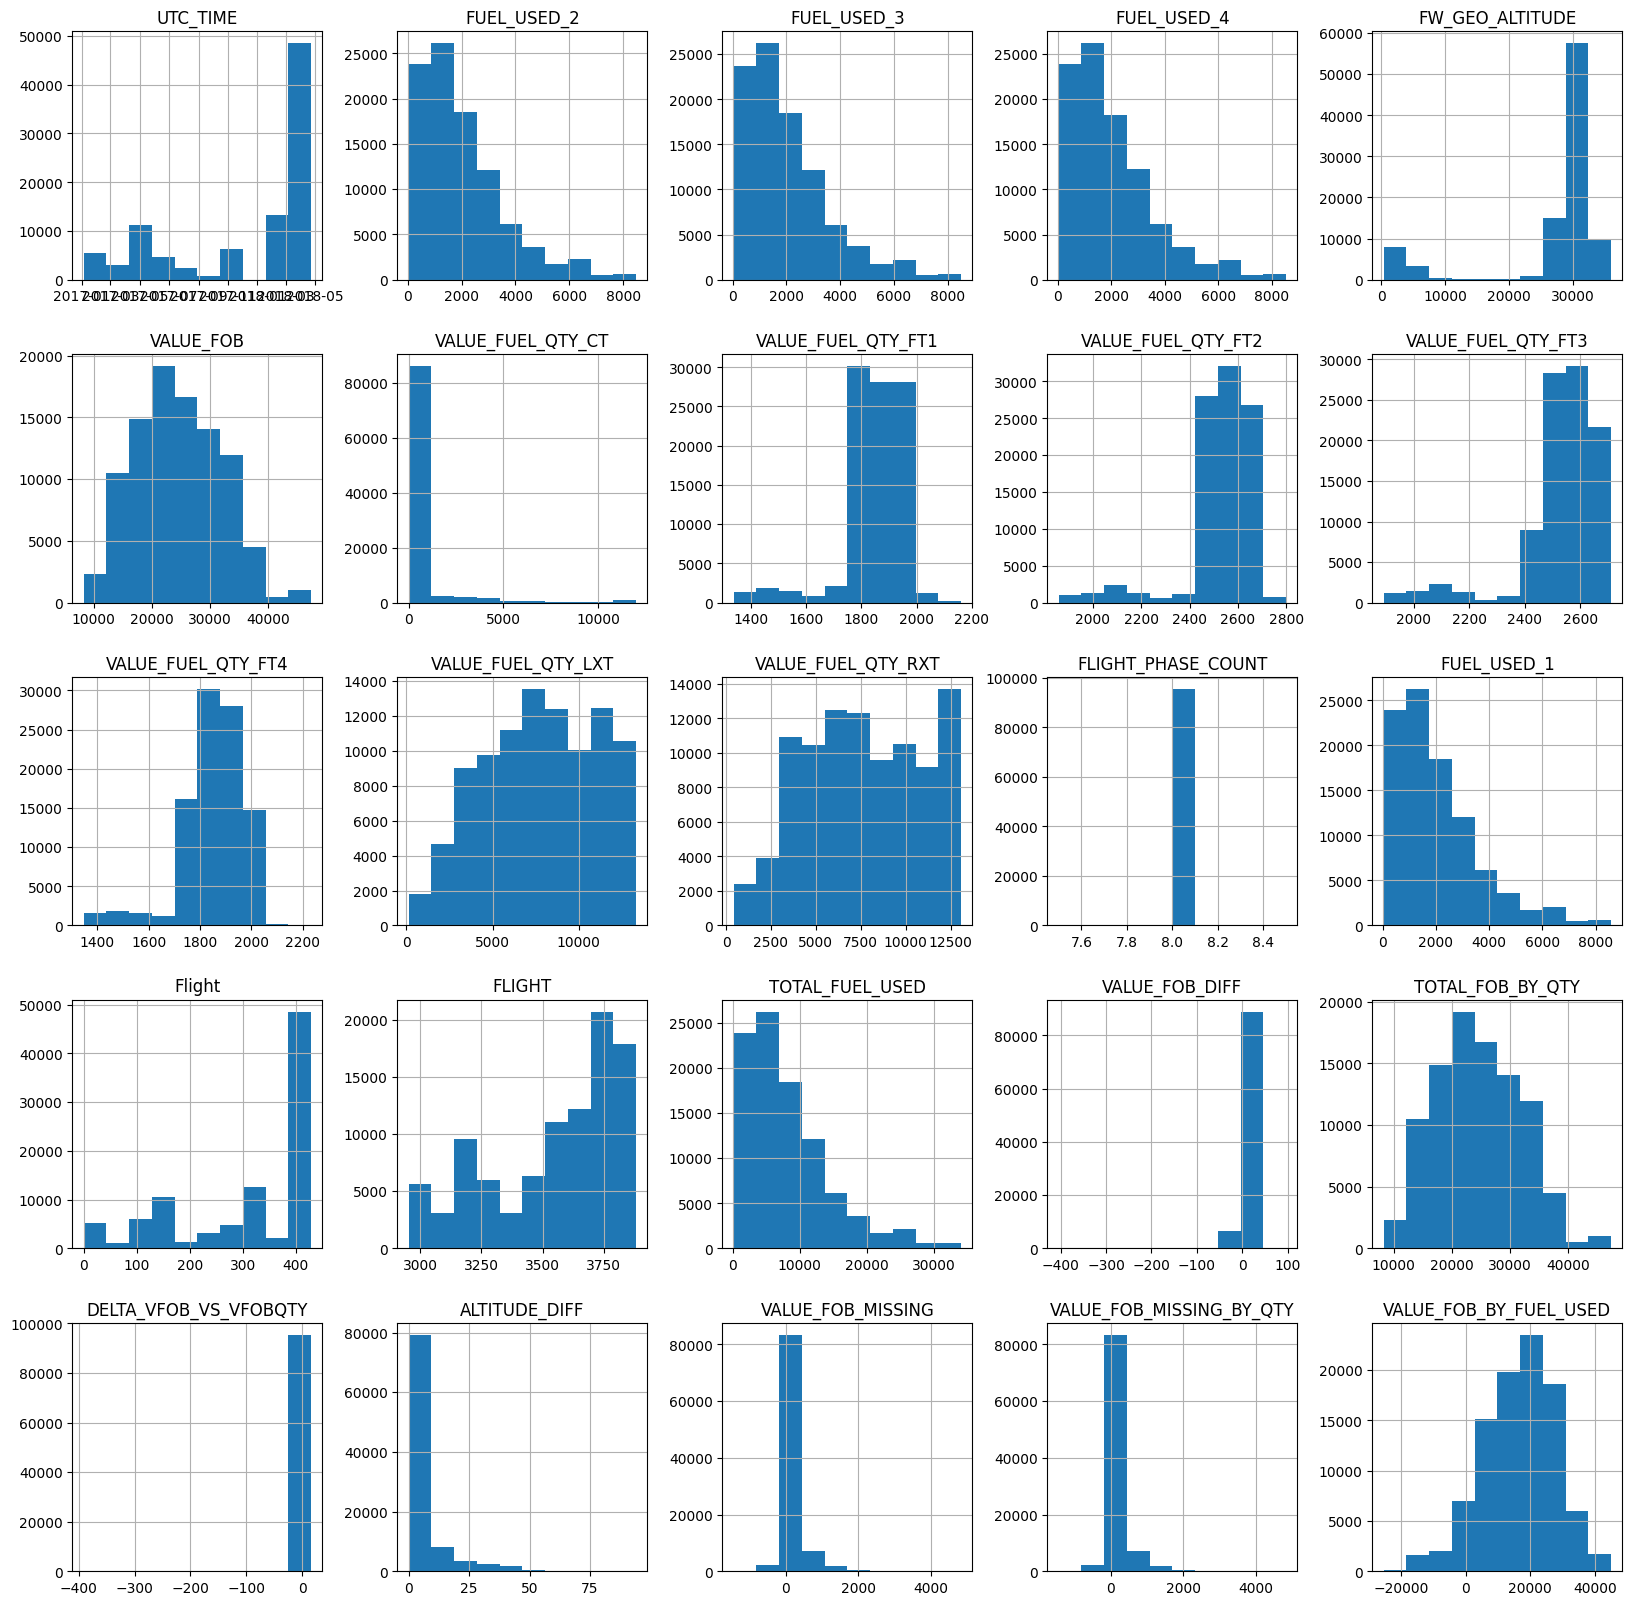

Dataset 7 shape: (96849, 28)
Dataset 7 unique flights: 516


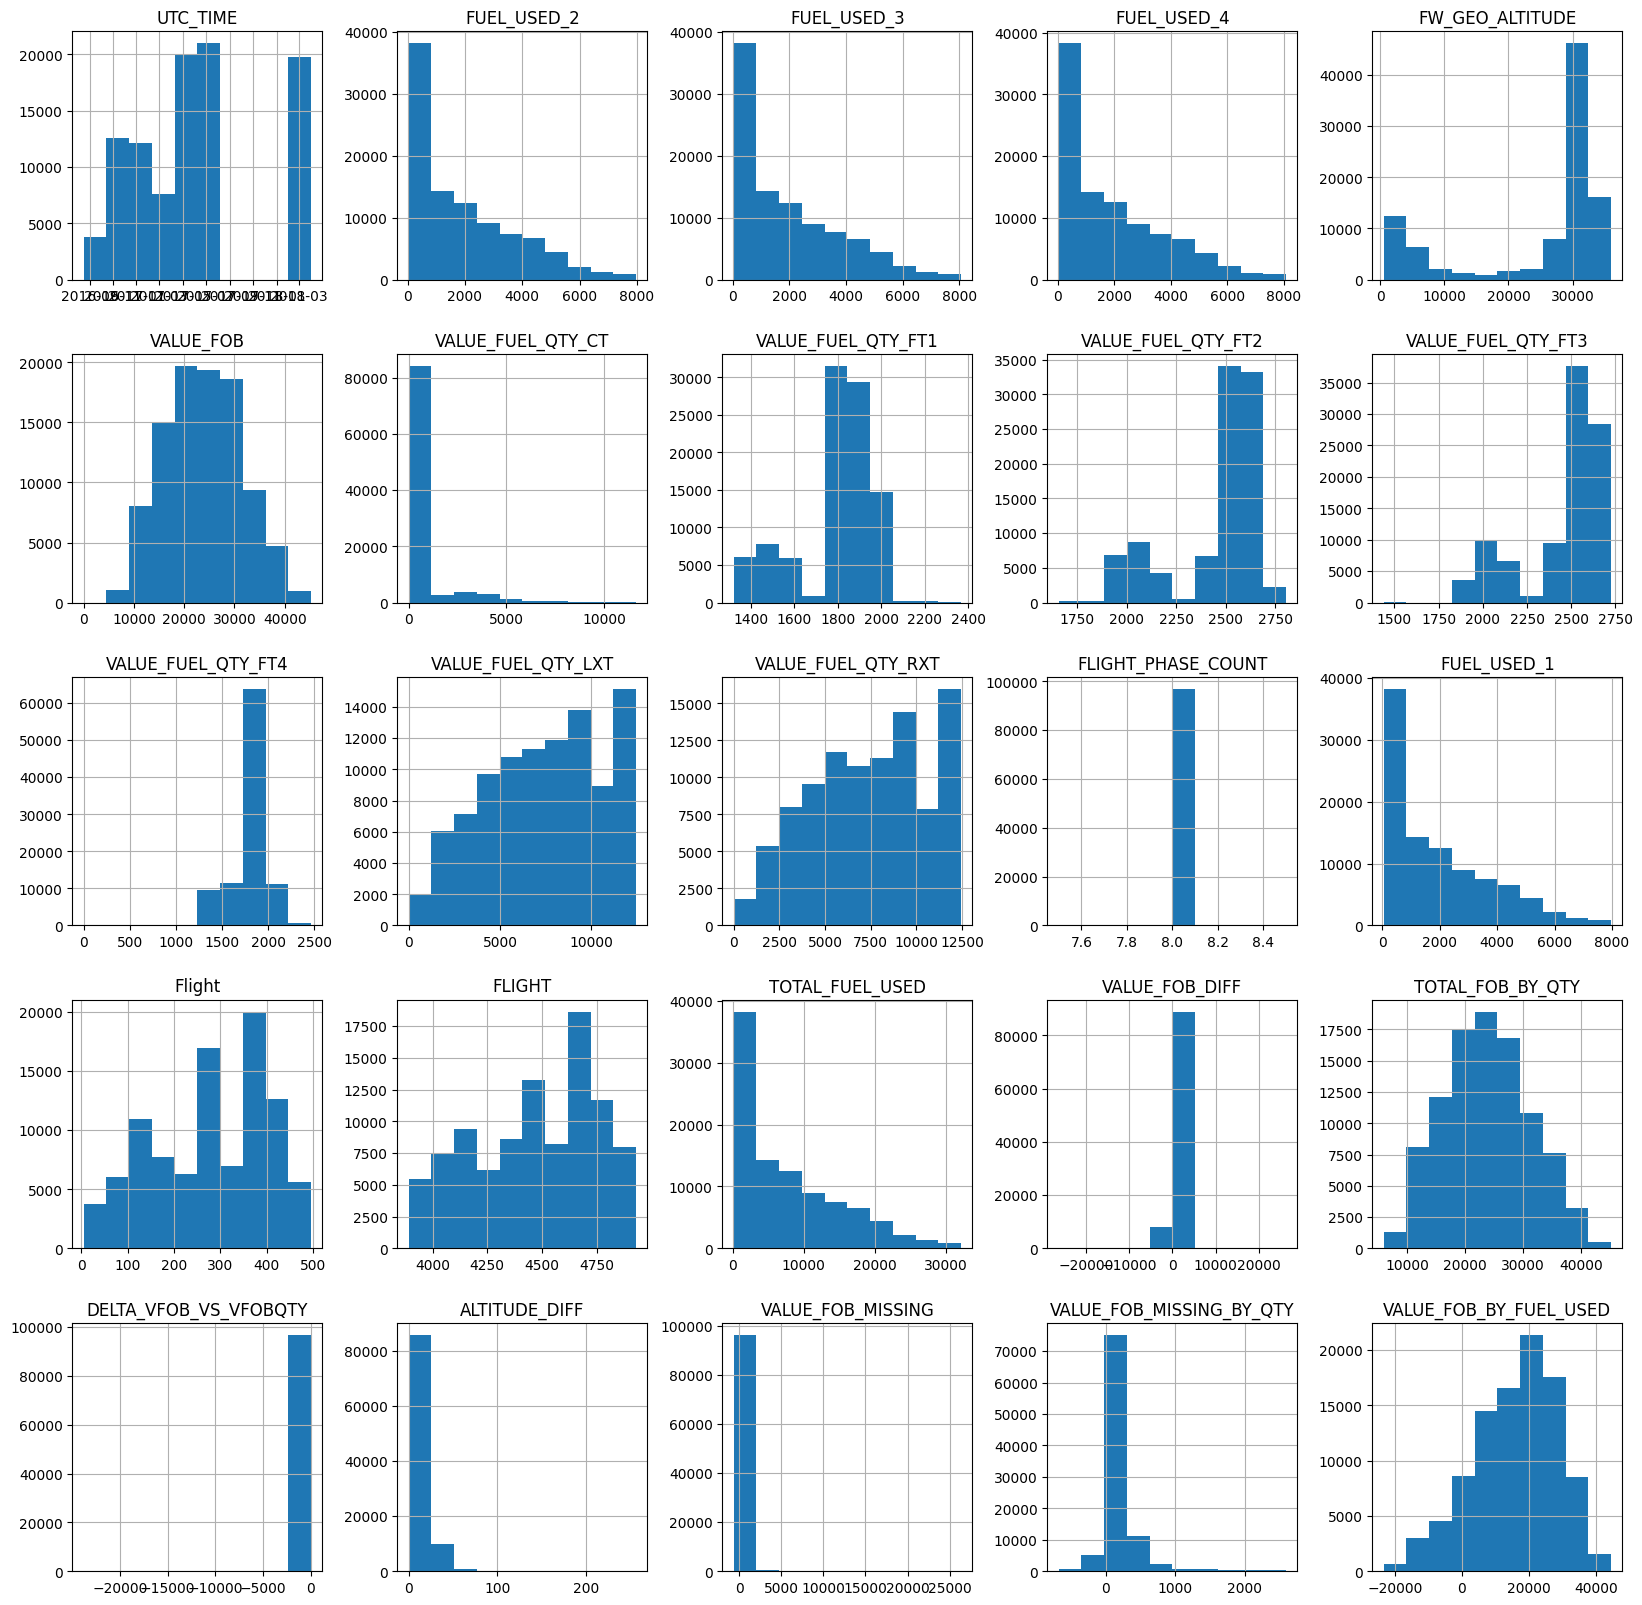

Dataset 8 shape: (96849, 28)
Dataset 8 unique flights: 516


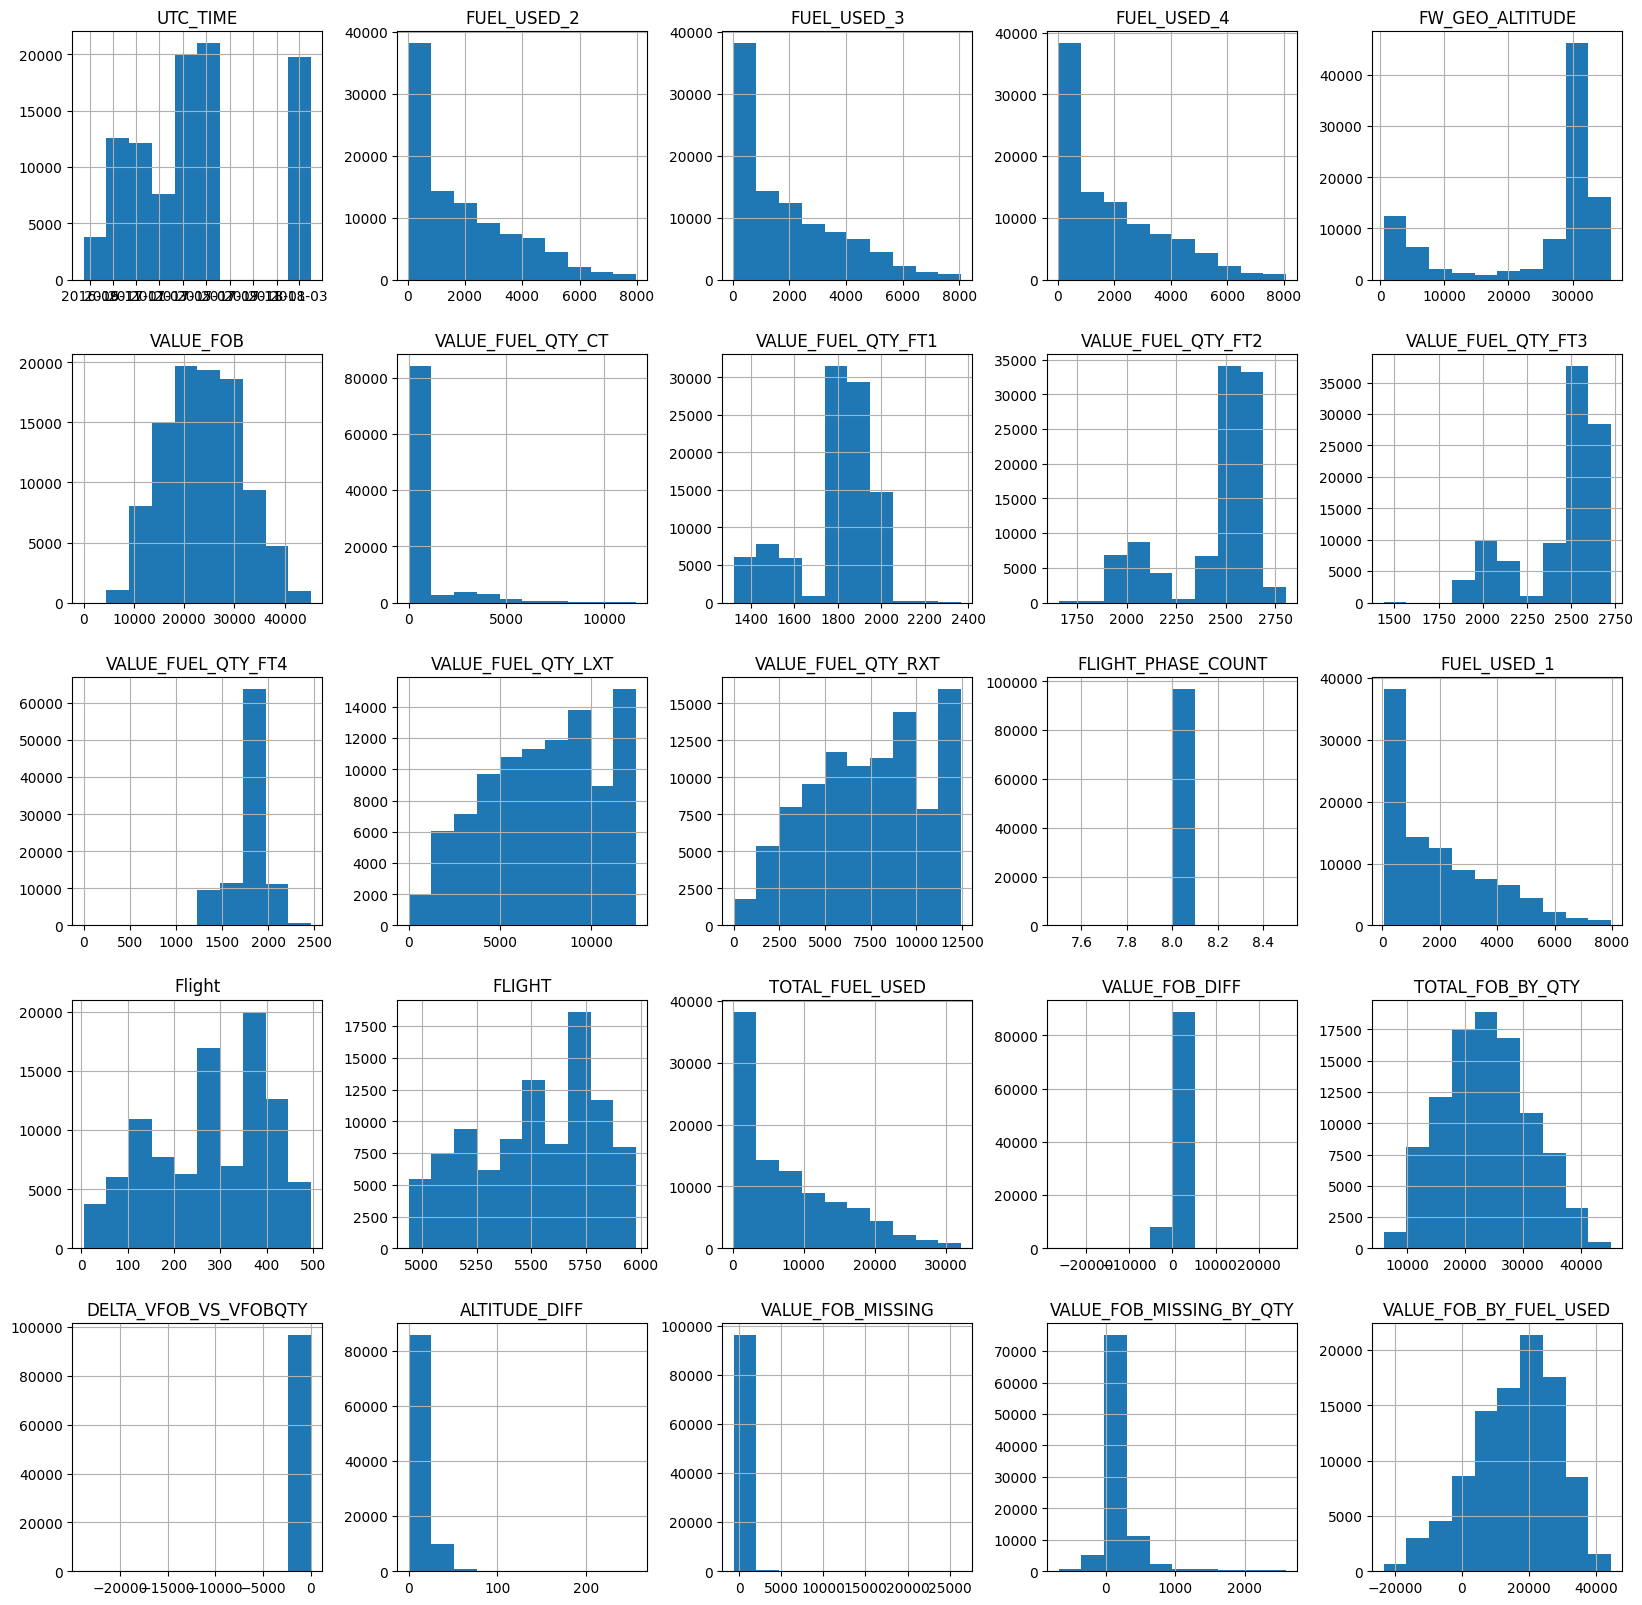

Dataset 9 shape: (96849, 28)
Dataset 9 unique flights: 516


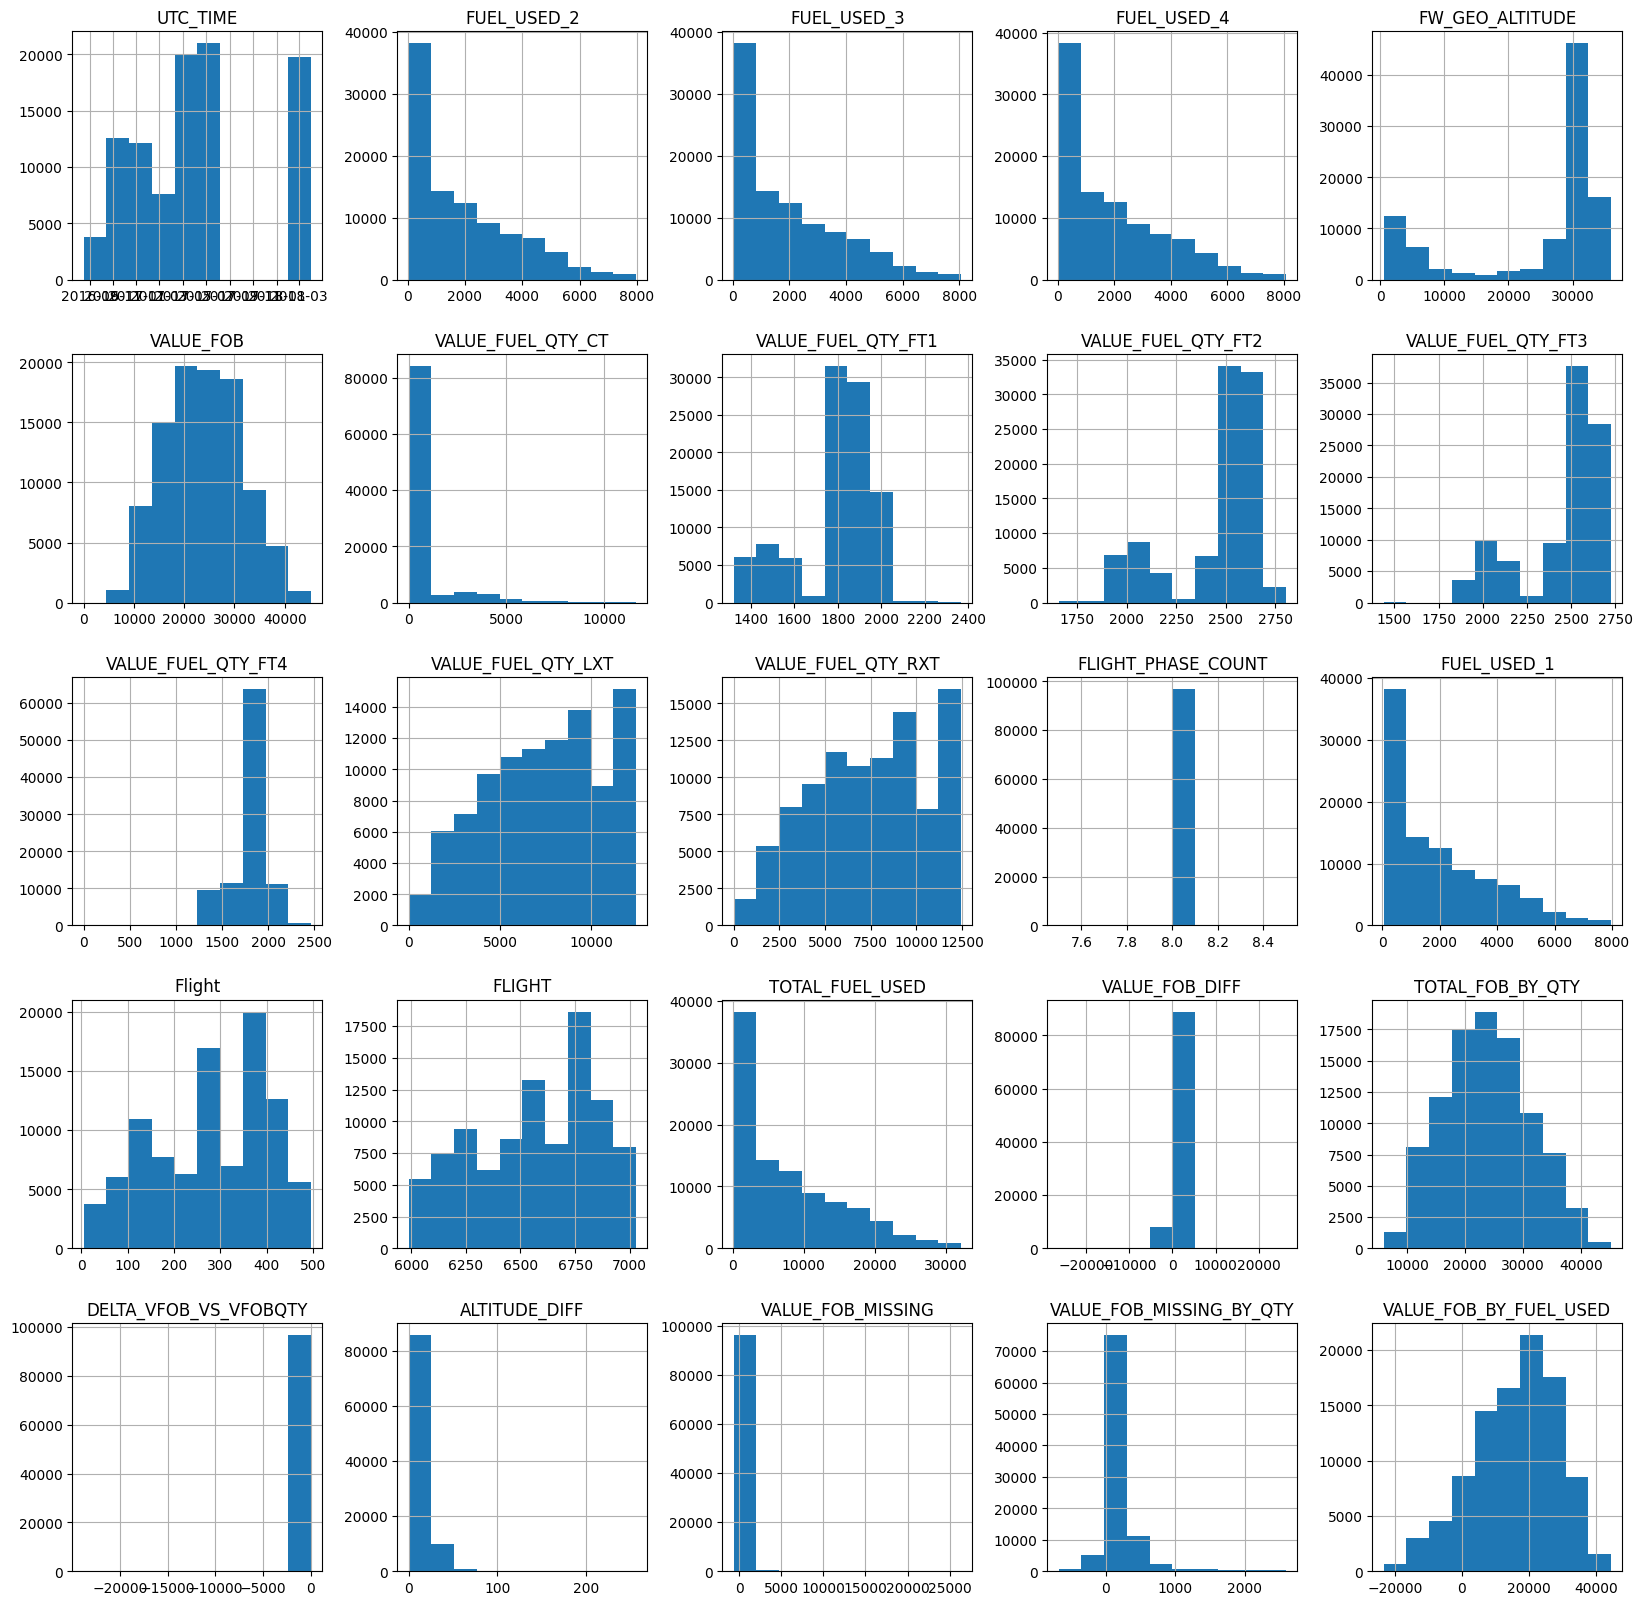

In [34]:
# distribution of the columns 
for i, dataset in enumerate(datasets_with_new_features):
    print(f'Dataset {i} shape: {dataset.shape}')
    print(f'Dataset {i} unique flights: {dataset["FLIGHT"].nunique()}')
    dataset.hist(figsize=(20,20))
    plt.show()

# Dropping Outliers

Since out data is not normally distributed most of the time we're using IQR for the outlier detection

In [35]:
# count number of outliers outside of 95% confidence interval
def drop_outliers(dataset):
    # create copy of dataset
    dataset_tmp = dataset.copy()
    
    for column in dataset_tmp.columns:
        # skip columns that are not numeric
        if dataset_tmp[column].dtype != 'float64':
            continue
        
        print(dataset_tmp.shape, column)
        
        # calculate 95% confidence interval
        lower_bound, upper_bound = np.percentile(dataset_tmp[column], [2.5, 97.5])
        
        # count number of outliers
        outliers = dataset_tmp[column][(dataset_tmp[column] < lower_bound) | (dataset_tmp[column] > upper_bound)]
        print(f'Column {column} has {outliers.shape[0]} outliers')
        
        # delete outliers
        dataset_tmp.drop(outliers.index, inplace=True)
        
    return dataset_tmp

In [36]:
datasets_without_outliers = [drop_outliers(dataset) for dataset in datasets_with_new_features]
datasets_without_outliers_with_fuel_leak = [drop_outliers(dataset) for dataset in datasets_with_new_features_with_fuel_leak]

(1839, 28) FLIGHT_PHASE_COUNT
Column FLIGHT_PHASE_COUNT has 0 outliers
(1839, 28) FUEL_USED_1
Column FUEL_USED_1 has 92 outliers
(1747, 28) FUEL_USED_2
Column FUEL_USED_2 has 88 outliers
(1659, 28) FUEL_USED_3
Column FUEL_USED_3 has 84 outliers
(1575, 28) FUEL_USED_4
Column FUEL_USED_4 has 80 outliers
(1495, 28) FW_GEO_ALTITUDE
Column FW_GEO_ALTITUDE has 76 outliers
(1419, 28) VALUE_FOB
Column VALUE_FOB has 72 outliers
(1347, 28) VALUE_FUEL_QTY_CT
Column VALUE_FUEL_QTY_CT has 28 outliers
(1319, 28) VALUE_FUEL_QTY_FT1
Column VALUE_FUEL_QTY_FT1 has 66 outliers
(1253, 28) VALUE_FUEL_QTY_FT2
Column VALUE_FUEL_QTY_FT2 has 58 outliers
(1195, 28) VALUE_FUEL_QTY_FT3
Column VALUE_FUEL_QTY_FT3 has 58 outliers
(1137, 28) VALUE_FUEL_QTY_FT4
Column VALUE_FUEL_QTY_FT4 has 50 outliers
(1087, 28) VALUE_FUEL_QTY_LXT
Column VALUE_FUEL_QTY_LXT has 56 outliers
(1031, 28) VALUE_FUEL_QTY_RXT
Column VALUE_FUEL_QTY_RXT has 43 outliers
(988, 28) FLIGHT
Column FLIGHT has 0 outliers
(988, 28) TOTAL_FUEL_USED
Col

In [37]:
datasets_without_outliers

[                  UTC_TIME     MSN Flight  FLIGHT_PHASE_COUNT  FUEL_USED_1  \
 34639  2016-10-07 07:52:18  MSN_02  V0926                 8.0     154.6462   
 34640  2016-10-07 07:52:19  MSN_02  V0926                 8.0     154.9432   
 34641  2016-10-07 07:52:20  MSN_02  V0926                 8.0     155.2400   
 34642  2016-10-07 07:52:21  MSN_02  V0926                 8.0     155.5376   
 34643  2016-10-07 07:52:22  MSN_02  V0926                 8.0     155.8405   
 ...                    ...     ...    ...                 ...          ...   
 589662 2016-10-07 12:15:37  MSN_02  V0927                 8.0     210.1636   
 589663 2016-10-07 12:15:38  MSN_02  V0927                 8.0     210.6341   
 589664 2016-10-07 12:15:39  MSN_02  V0927                 8.0     211.1465   
 589665 2016-10-07 12:15:40  MSN_02  V0927                 8.0     211.6195   
 589666 2016-10-07 12:15:41  MSN_02  V0927                 8.0     212.0914   
 
         FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW

## Merge all datasets

In [38]:
# merge all datasets into one
merged_dataset = pd.concat(datasets_without_outliers)
merged_dataset_with_fuel_leak = pd.concat(datasets_without_outliers_with_fuel_leak)

In [39]:
# drop flights that are no longer than 180 seconds
for flight in merged_dataset["FLIGHT"].unique():
    flight_data = merged_dataset[merged_dataset["FLIGHT"] == flight]
    if flight_data.shape[0] < 180:
        merged_dataset.drop(flight_data.index, inplace=True)
    

In [40]:
# drop column FLIGHT_PHASE_COUNT since it is unnecessary
merged_dataset.drop(['FLIGHT_PHASE_COUNT'], axis=1, inplace=True)
merged_dataset_with_fuel_leak.drop('FLIGHT_PHASE_COUNT', axis=1, inplace=True)

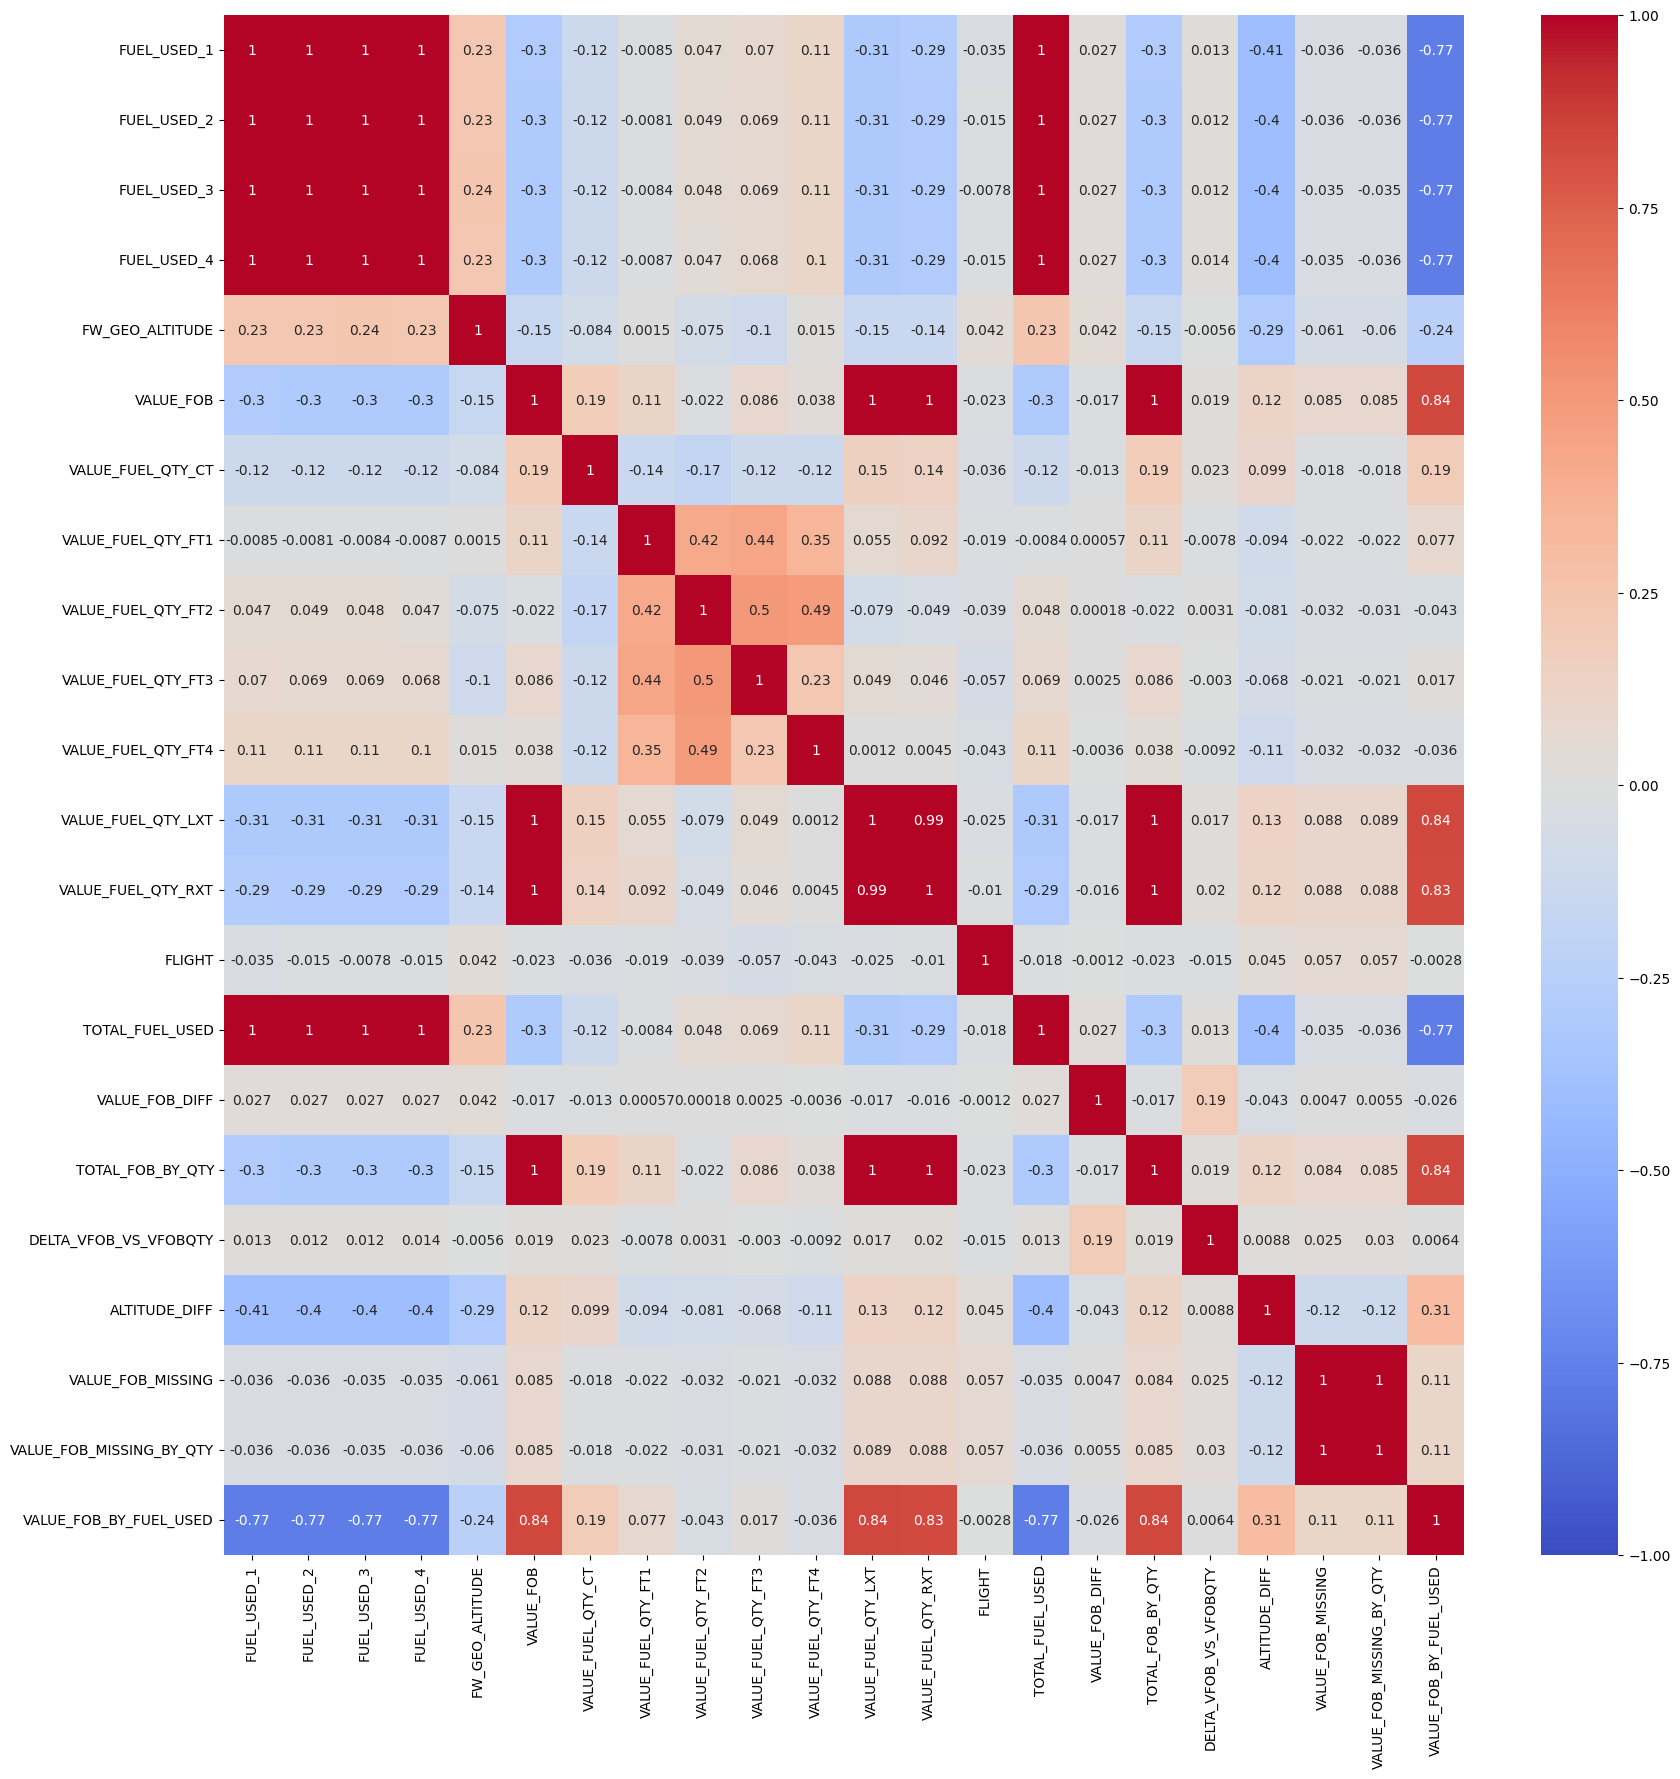

In [41]:
import seaborn as sns

# heatmap for numeric columns
fig = plt.figure(figsize=(20, 20))
sns.heatmap(merged_dataset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [42]:
# if not exists, create generated_data folder
if not os.path.exists('generated_data'):
    os.makedirs('generated_data')

# save datasets into generated_data folder
merged_dataset.to_csv('generated_data/merged_dataset.csv', index=False)
merged_dataset_with_fuel_leak.to_csv('generated_data/merged_dataset_with_fuel_leak.csv', index=False)

<IPython.core.display.Javascript object>

In [43]:
# save the columns that are not diffed of the two datasets
utc_with_leak = list(merged_dataset_with_fuel_leak['UTC_TIME'])
flight_with_leak = list(merged_dataset_with_fuel_leak['Flight'])
index_with_leak = list(merged_dataset_with_fuel_leak.index)
msn_with_leak = list(merged_dataset_with_fuel_leak['MSN'])

utc_normal = list(merged_dataset['UTC_TIME'])
flight_normal = list(merged_dataset['Flight'])
index_normal = list(merged_dataset.index)
msn_normal = list(merged_dataset['MSN'])

## Get Derivated Dataset

In [44]:
numeric_columns = merged_dataset.select_dtypes(include=['float64']).columns

In [45]:
# new dataset with resampled data diff for numeric  columns
merged_dataset_diff = pd.DataFrame()
merged_dataset_with_fuel_leak_diff = pd.DataFrame()
 
for column in numeric_columns:
    if column == 'ALTITUDE_DIFF' or column == 'VALUE_FOB_DIFF' or column == 'FLIGHT':
        merged_dataset_diff[column] = merged_dataset[column]
        merged_dataset_with_fuel_leak_diff[column] = merged_dataset_with_fuel_leak[column]
    merged_dataset_diff[column] = merged_dataset[column].diff()
    merged_dataset_with_fuel_leak_diff[column] = merged_dataset_with_fuel_leak[column].diff()
    
# fillna with 0
merged_dataset_diff.fillna(0, inplace=True)
merged_dataset_with_fuel_leak_diff.fillna(0, inplace=True)

In [46]:
merged_dataset_diff

FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
41994       0.000000     0.000000     0.000000     0.000000            0.000   
41995       0.497200     0.492900     0.488600     0.498700           20.649   
41996       0.496300     0.537300     0.489300     0.500200           18.480   
41997       0.498500     0.489700     0.488400     0.497400           26.295   
41999       0.993400     0.983700     0.976900     0.994300           57.469   
...              ...          ...          ...          ...              ...   
2870710     0.422852     0.372803     0.378174     0.376709          -14.000   
2870711     0.422363     0.375000     0.380371     0.423828           10.000   
2870712     0.328613     0.376221     0.378418     0.329590            3.000   
2870713     0.421387     0.419434     0.428467     0.424561          -10.000   
2870714     0.046875     0.046875     0.047852     0.046875           -1.000   

         VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  VALUE_FUEL_QTY_FT2  \
41994          0.0                0.0                 0.0                 0.0   
41995         -8.0                0.0                -2.0                -2.0   
41996         -5.0                0.0                 1.0                 2.0   
41997         -5.0                0.0                 0.0                 4.0   
41999         -6.0                0.0                -2.0                 6.0   
...            ...                ...                 ...                 ...   
2870710       -1.0                0.0                 0.0                 0.0   
2870711        1.0                0.0                 0.0                 1.0   
2870712       -3.0                0.0                -1.0                -1.0   
2870713       -1.0                0.0                 0.0                -1.0   
2870714       -1.0                0.0                -1.0                -1.0   

         VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  VALUE_FUEL_QTY_LXT  \
41994                   0.0                 0.0                 0.0   
41995                   5.0                 0.0                -4.0   
41996                   2.0                -1.0                -6.0   
41997                   2.0                -1.0                 0.0   
41999                   6.0                 2.0               -11.0   
...                     ...                 ...                 ...   
2870710                -1.0                 0.0                -1.0   
2870711                -1.0                -1.0                 1.0   
2870712                 0.0                 0.0                 0.0   
2870713                 0.0                 0.0                 0.0   
2870714                 0.0                 0.0                -2.0   

         VALUE_FUEL_QTY_RXT  FLIGHT  TOTAL_FUEL_USED  VALUE_FOB_DIFF  \
41994                   0.0     0.0         0.000000             0.0   
41995                  -3.0     0.0         1.977400            -4.0   
41996                  -7.0     0.0         2.023100             3.0   
41997                  -9.0     0.0         1.974000             0.0   
41999                  -6.0     0.0         3.948300             5.0   
...                     ...     ...              ...             ...   
2870710                 1.0     0.0         1.550537             1.0   
2870711                 0.0     0.0         1.601562             2.0   
2870712                 0.0     0.0         1.412842            -4.0   
2870713                 0.0     0.0         1.693848             2.0   
2870714                 2.0     0.0         0.188477             0.0   

         TOTAL_FOB_BY_QTY  DELTA_VFOB_VS_VFOBQTY  ALTITUDE_DIFF  \
41994                 0.0                    0.0          0.000   
41995                -6.0                   -2.0          3.806   
41996                -9.0                    4.0         -2.169   
41997                -4.0                   -1.0          7.815   
41999                -

In [47]:
merged_dataset_with_fuel_leak_diff

FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
34639       0.000000     0.000000     0.000000     0.000000            0.000   
34640       0.297000     0.296900     0.325400     0.301000            0.658   
34641       0.296800     0.296800     0.297300     0.301700            0.750   
34642       0.297600     0.297800     0.298700     0.330900            1.030   
34643       0.302900     0.302700     0.302500     0.308000            0.997   
...              ...          ...          ...          ...              ...   
2904028     0.292725     0.327148     0.295166     0.297363            2.000   
2904029     0.326904     0.291260     0.328613     0.332520            0.000   
2904030     0.289307     0.288086     0.256348     0.295410           -1.000   
2904031     0.325684     0.290527     0.330811     0.332520            2.000   
2904032     0.036377     0.036377     0.036865     0.036865           -3.000   

         VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  VALUE_FUEL_QTY_FT2  \
34639          0.0                0.0                 0.0                 0.0   
34640         -1.0                0.0                 0.0                 0.0   
34641          2.0                0.0                -1.0                 0.0   
34642          1.0                0.0                 0.0                -1.0   
34643          1.0                0.0                -1.0                -1.0   
...            ...                ...                 ...                 ...   
2904028       -5.0                1.0                -1.0                -1.0   
2904029       -5.0                0.0                 0.0                 0.0   
2904030       -3.0                1.0                 0.0                 0.0   
2904031      -11.0               -3.0                 0.0                 0.0   
2904032       -6.0               -1.0                 0.0                 0.0   

         VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  VALUE_FUEL_QTY_LXT  \
34639                   0.0                 0.0                 0.0   
34640                   2.0                 2.0                 2.0   
34641                   1.0                 1.0                 3.0   
34642                   2.0                 2.0                 1.0   
34643                   2.0                 1.0                 3.0   
...                     ...                 ...                 ...   
2904028                 0.0                -5.0                -1.0   
2904029                 0.0                -5.0                -1.0   
2904030                -1.0                -6.0                 2.0   
2904031                -1.0                -5.0                 0.0   
2904032                -1.0                -6.0                 1.0   

         VALUE_FUEL_QTY_RXT  FLIGHT  TOTAL_FUEL_USED  VALUE_FOB_DIFF  \
34639                   0.0     0.0         0.000000             0.0   
34640                  -4.0     0.0         1.220300            -1.0   
34641                  -3.0     0.0         1.192600             3.0   
34642                  -3.0     0.0         1.225000            -1.0   
34643                  -3.0     0.0         1.216100             0.0   
...                     ...     ...              ...             ...   
2904028                 1.0     0.0         1.212402             2.0   
2904029                 2.0     0.0         1.279297             0.0   
2904030                -1.0     0.0         1.129150             2.0   
2904031                 0.0     0.0         1.279541            -8.0   
2904032                 0.0     0.0         0.146484             5.0   

         TOTAL_FOB_BY_QTY  DELTA_VFOB_VS_VFOBQTY  ALTITUDE_DIFF  \
34639                 0.0                    0.0          0.000   
34640                 2.0                   -3.0          0.217   
34641                 1.0                    1.0          0.092   
34642                 1.0                    0.0          0.280   
34643                 

In [48]:
# drop FLIGHT column in both datasets
merged_dataset_diff.drop('FLIGHT', axis=1, inplace=True)
merged_dataset_with_fuel_leak_diff.drop('FLIGHT', axis=1, inplace=True)

In [49]:
numeric_columns = merged_dataset_diff.select_dtypes(include=['float64']).columns
numeric_columns

Index(['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4',
       'FW_GEO_ALTITUDE', 'VALUE_FOB', 'VALUE_FUEL_QTY_CT',
       'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3',
       'VALUE_FUEL_QTY_FT4', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT',
       'TOTAL_FUEL_USED', 'VALUE_FOB_DIFF', 'TOTAL_FOB_BY_QTY',
       'DELTA_VFOB_VS_VFOBQTY', 'ALTITUDE_DIFF', 'VALUE_FOB_MISSING',
       'VALUE_FOB_MISSING_BY_QTY', 'VALUE_FOB_BY_FUEL_USED'],
      dtype='object')

In [50]:
# save datasets into generated_data folder
merged_dataset_diff.to_csv('generated_data/merged_dataset_diff.csv', index=False)
merged_dataset_with_fuel_leak_diff.to_csv('generated_data/merged_dataset_with_fuel_leak_diff.csv', index=False)

## Scaling

In [51]:
# define scaler
scaler = StandardScaler()
 
# fit_transform on merged dataset
scaled_data = scaler.fit_transform(merged_dataset_diff[numeric_columns])
scaled_data_with_fuel_leak = scaler.fit_transform(merged_dataset_with_fuel_leak_diff[numeric_columns])

# convert scaled_dataset to dataframe
scaled_dataset = pd.DataFrame(scaled_data, columns=numeric_columns)
scaled_dataset_with_fuel_leak = pd.DataFrame(scaled_data_with_fuel_leak, columns=numeric_columns)

scaled_dataset

FUEL_USED_1  FUEL_USED_2  FUEL_USED_3  FUEL_USED_4  FW_GEO_ALTITUDE  \
0         -0.000306    -0.000316    -0.000317    -0.000310        -0.001267   
1          0.006700     0.006688     0.006551     0.006656         0.116337   
2          0.006687     0.007319     0.006560     0.006677         0.103983   
3          0.006718     0.006643     0.006548     0.006638         0.148493   
4          0.013692     0.013663     0.013414     0.013579         0.326041   
...             ...          ...          ...          ...              ...   
112431     0.005652     0.004981     0.004999     0.004952        -0.081003   
112432     0.005646     0.005013     0.005029     0.005611         0.055687   
112433     0.004325     0.005030     0.005002     0.004294         0.015819   
112434     0.005632     0.005644     0.005705     0.005621        -0.058221   
112435     0.000355     0.000350     0.000356     0.000345        -0.006963   

        VALUE_FOB  VALUE_FUEL_QTY_CT  VALUE_FUEL_QTY_FT1  VALUE_FUEL_QTY_FT2  \
0       -0.000135                0.0            0.000042            0.000145   
1       -0.026452                0.0           -0.279198           -0.305176   
2       -0.016583                0.0            0.139662            0.305467   
3       -0.016583                0.0            0.000042            0.610788   
4       -0.019873                0.0           -0.279198            0.916109   
...           ...                ...                 ...                 ...   
112431  -0.003425                0.0            0.000042            0.000145   
112432   0.003155                0.0            0.000042            0.152806   
112433  -0.010004                0.0           -0.139578           -0.152515   
112434  -0.003425                0.0            0.000042           -0.152515   
112435  -0.003425                0.0           -0.139578           -0.152515   

        VALUE_FUEL_QTY_FT3  VALUE_FUEL_QTY_FT4  VALUE_FUEL_QTY_LXT  \
0                 0.000155            0.000081           -0.000138   
1                 0.664281            0.000081           -0.026795   
2                 0.265805           -0.142822           -0.040123   
3                 0.265805           -0.142822           -0.000138   
4                 0.797107            0.285889           -0.073444   
...                    ...                 ...                 ...   
112431           -0.132671            0.000081           -0.006802   
112432           -0.132671           -0.142822            0.006526   
112433            0.000155            0.000081           -0.000138   
112434            0.000155            0.000081           -0.000138   
112435            0.000155            0.000081           -0.013466   

        VALUE_FUEL_QTY_RXT  TOTAL_FUEL_USED  VALUE_FOB_DIFF  TOTAL_FOB_BY_QTY  \
0                -0.000155        -0.000312       -0.000012         -0.000135   
1                -0.020082         0.006649       -1.783275         -0.019872   
2                -0.046653         0.006810        1.337435         -0.029741   
3                -0.059938         0.006637       -0.000012         -0.013293   
4                -0.040010         0.013588        2.229067         -0.016583   
...                    ...              ...             ...               ...   
112431            0.006488         0.005147        0.445804         -0.003424   
112432           -0.000155         0.005326        0.891620         -0.000135   
112433           -0.000155         0.004662       -1.783275         -0.006714   
112434           -0.000155         0.005651        0.891620         -0.003424   
112435            0.013131         0.000351       -0.000012         -0.006714   

        DELTA_VFOB_VS_VFOBQTY  ALTITUDE_DIFF  VALUE_FOB_MISSING  \
0                   -0.000007       0.000029          -0.000083   
1                   -1.663681       0.779250           0.269239   
2                    3.327339      -0.444041           0.168243   
3               

In [52]:
np.mean(scaled_data),np.std(scaled_data)

(-1.6460872405752724e-18, 0.9999999999999994)

In [53]:
# save scaled dataset to csv
scaled_dataset.to_csv('generated_data/scaled_dataset.csv', index=False)
scaled_dataset_with_fuel_leak.to_csv('generated_data/scaled_dataset_with_fuel_leak.csv', index=False) 

## PCA without Synthetic Leak Data

In [54]:
scaled_data = pd.read_csv('generated_data/scaled_dataset.csv')
scaled_data_with_fuel_leak = pd.read_csv('generated_data/scaled_dataset_with_fuel_leak.csv')

In [55]:
num_components = 15

# Create a PCA instance
pca = PCA()  

# Fit PCA on scaled_data
pca.fit(scaled_data)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, len(pca.components_)+1)])

[[-3.15607930e-01 -3.16293525e-01 -3.16178542e-01 -3.15762138e-01
  -2.16941156e-01  2.82310993e-01  8.48676047e-02 -2.72619422e-02
  -3.93865053e-02 -2.68193643e-02 -4.87409072e-02  2.85318743e-01
   2.80068908e-01 -3.15994400e-01 -1.46435471e-03  2.82307334e-01
  -2.14514763e-03  1.52956351e-02 -1.98988052e-02 -1.98594821e-02
   3.47698391e-01]
 [ 2.46498239e-01  2.44839474e-01  2.45700040e-01  2.46670300e-01
  -1.70752936e-02  3.43790133e-01  6.33864257e-02  1.63997751e-01
   2.16155179e-01  1.63396931e-01  2.00794982e-01  3.19099681e-01
   3.32375975e-01  2.45957943e-01 -1.30282388e-03  3.43821971e-01
  -1.17899619e-02  4.52312689e-03 -2.24137151e-01 -2.24595324e-01
   5.56057948e-02]
 [-1.24520100e-01 -1.22283605e-01 -1.22248354e-01 -1.23448966e-01
  -2.27741819e-01 -1.69639555e-01 -1.31838344e-01  2.53914076e-01
   2.67744662e-01  2.57369644e-01  1.51530716e-01 -1.82872002e-01
  -1.85041695e-01 -1.23140788e-01  1.50647983e-02 -1.69690257e-01
   1.46661560e-02  4.79389544e-02 -4.9

In [56]:
pca_dataset.to_csv('generated_data/pca_dataset.csv', index=False)

In [57]:
explained_var = pca.explained_variance_ratio_

cumulative_var = np.cumsum(explained_var)

explained_var, cumulative_var

n_components = len(explained_var)

variance_trace = go.Bar(
    x=list(range(1, n_components + 1)),
    y=explained_var,
    name='Explained Variance'
)

cumulative_trace = go.Scatter(
    x=list(range(1, n_components + 1)),
    y=cumulative_var,
    mode='lines',
    name='Cumulative Explained Variance'
)

layout = go.Layout(
    title='PCA - Explained and Cumulative Variance',
    xaxis=dict(title='Principal Component'),
    yaxis=dict(title='Variance Explained'),
    legend=dict(x=0.7, y=1.0),
    template='plotly_dark'
)

fig = go.Figure(data=[variance_trace, cumulative_trace], layout=layout)

fig.show()


In [58]:
figures = []

for i, pc in enumerate(pca.components_, 1):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=scaled_data.columns, y=pc))
    fig.update_layout(title=f"Principal Component {i}", xaxis_title="Features", yaxis_title="PC Value", template='plotly_dark')
    figures.append(fig)
for fig in figures[0:6]:
    fig.show()

## PCA with Leakage

In [59]:
num_components = 10

# Create a PCA instance
pca_with_fuel_leak = PCA()  

# Fit PCA on scaled_data
pca.fit(scaled_data_with_fuel_leak)
 
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
 
# transform data 
pca_data = pca.transform(scaled_data)
 
# convert pca_data to dataframe
pca_dataset_with_fuel_leak = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, len(pca.components_)+1)])
pca_dataset_with_fuel_leak.to_csv('generated_data/pca_dataset_with_fuel_leak.csv', index=False)

[[-3.20284070e-01 -3.20357737e-01 -3.20277338e-01 -3.20402886e-01
  -9.88482950e-02  2.88225005e-01  1.24013971e-01 -1.62845520e-02
  -2.02477403e-02 -2.17311832e-02 -4.41580609e-03  2.91685048e-01
   2.88327435e-01 -3.20361774e-01  1.67359166e-03  2.88413905e-01
  -1.33726020e-03  1.10134612e-02  3.20209233e-03  3.22843248e-03
   3.54948955e-01]
 [ 1.21451415e-01  1.21889209e-01  1.21742181e-01  1.21630261e-01
   1.63365404e-01  2.08877427e-01  6.74744231e-02  2.08419469e-01
   2.07847627e-01  2.36106712e-01  4.30836695e-01  1.51657771e-01
   1.57157364e-01  1.21689760e-01  1.08438119e-02  2.05426390e-01
   2.52583009e-01 -2.41592445e-03 -4.34478754e-01 -4.23634526e-01
   3.21589610e-02]
 [-1.65618690e-01 -1.66161863e-01 -1.65926827e-01 -1.65591474e-01
  -3.02663981e-01 -2.27761785e-01 -7.70971660e-02 -2.36618601e-01
  -2.36604034e-01 -2.31869040e-01  2.68307792e-01 -2.33134687e-01
  -2.35072839e-01 -1.65840033e-01  8.58337038e-03 -2.30740448e-01
   2.01004166e-01  3.11645527e-02 -3.6

In [60]:
explained_var = pca.explained_variance_ratio_

cumulative_var = np.cumsum(explained_var)

explained_var, cumulative_var

n_components = len(explained_var)

variance_trace = go.Bar(
    x=list(range(1, n_components + 1)),
    y=explained_var,
    name='Explained Variance'
)

cumulative_trace = go.Scatter(
    x=list(range(1, n_components + 1)),
    y=cumulative_var,
    mode='lines',
    name='Cumulative Explained Variance'
)

layout = go.Layout(
    title='PCA - Explained and Cumulative Variance',
    xaxis=dict(title='Principal Component'),
    yaxis=dict(title='Variance Explained'),
    legend=dict(x=0.7, y=1.0),
    template='plotly_dark'
)

fig = go.Figure(data=[variance_trace, cumulative_trace], layout=layout)

fig.show()

In [61]:
figures = []

for i, pc in enumerate(pca.components_, 1):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=scaled_data.columns, y=pc))
    fig.update_layout(title=f"Principal Component {i}", xaxis_title="Features", yaxis_title="PC Value", template='plotly_dark')
    figures.append(fig)
for fig in figures[0:6]:
    fig.show()

### Check PCA with colorcodes by dataset

In [62]:
targets = ["MSN_02", "MSN_11", "MSN_12", "MSN_14", "MSN_29", "MSN_37", "MSN_53", "MSN_37_LEAK0.5", "MSN_37_LEAK1.0", "MSN_37_LEAK5.0"]
colors = ['lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'b', 'c', 'm']

In [63]:
pca_msn = PCA(n_components=3)
principalcomponents_msn = pca_msn.fit_transform(scaled_data)

In [64]:
X_pca3 = pd.DataFrame(data = principalcomponents_msn, columns=["PC1", "PC2", "PC3"])
X_pca3.insert(0, "MSN", msn_normal)

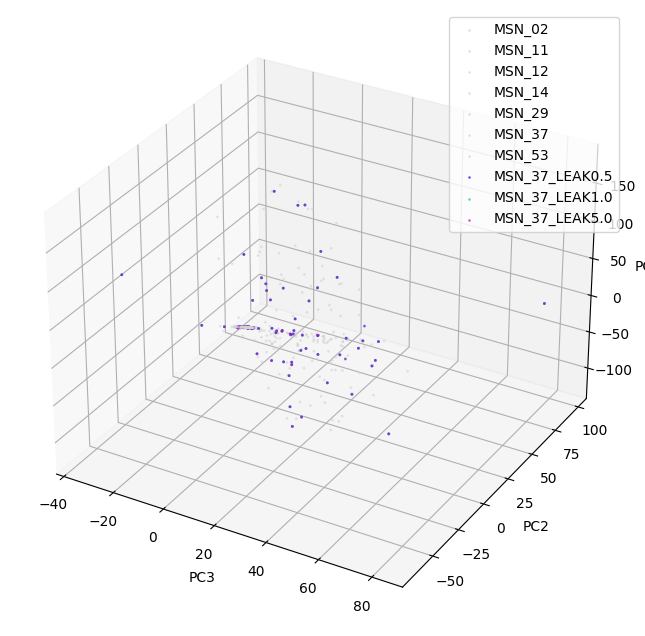

In [65]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')

for target, color in zip(targets,colors):
    indicesToKeep = X_pca3['MSN'] == target
    ax.scatter(X_pca3.loc[indicesToKeep, 'PC3']
               , X_pca3.loc[indicesToKeep, 'PC2']
               , X_pca3.loc[indicesToKeep, 'PC1']
               , c = color
               ,s = 1, 
               alpha = 0.5)
ax.legend(targets)
ax.grid()
plt.show()

In [66]:
pca_msn = PCA(n_components=3)
principalcomponents_msn = pca_msn.fit_transform(scaled_data_with_fuel_leak)

In [67]:
X_pca3 = pd.DataFrame(data = principalcomponents_msn, columns=["PC1", "PC2", "PC3"])
X_pca3.insert(0, "MSN", msn_with_leak)

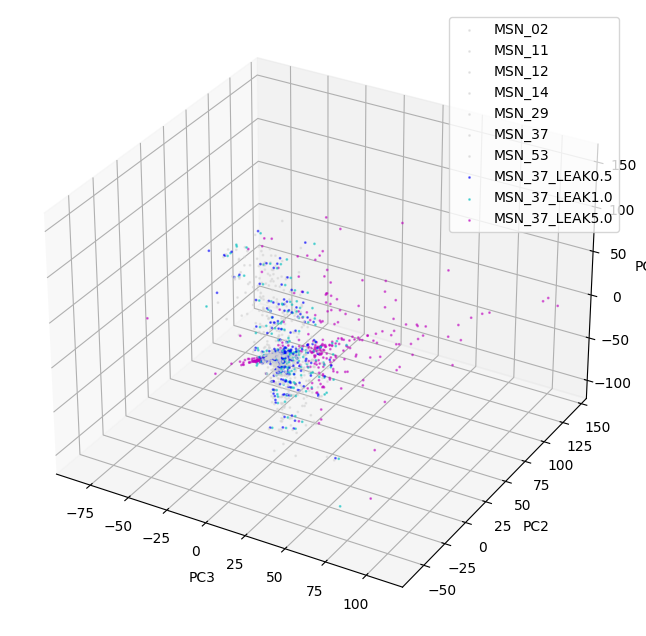

In [68]:
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1')

for target, color in zip(targets,colors):
    indicesToKeep = X_pca3['MSN'] == target
    ax.scatter(X_pca3.loc[indicesToKeep, 'PC3']
               , X_pca3.loc[indicesToKeep, 'PC2']
               , X_pca3.loc[indicesToKeep, 'PC1']
               , c = color
               ,s = 1, 
               alpha = 0.5)
ax.legend(targets)
ax.grid()
plt.show()

## Algorithms

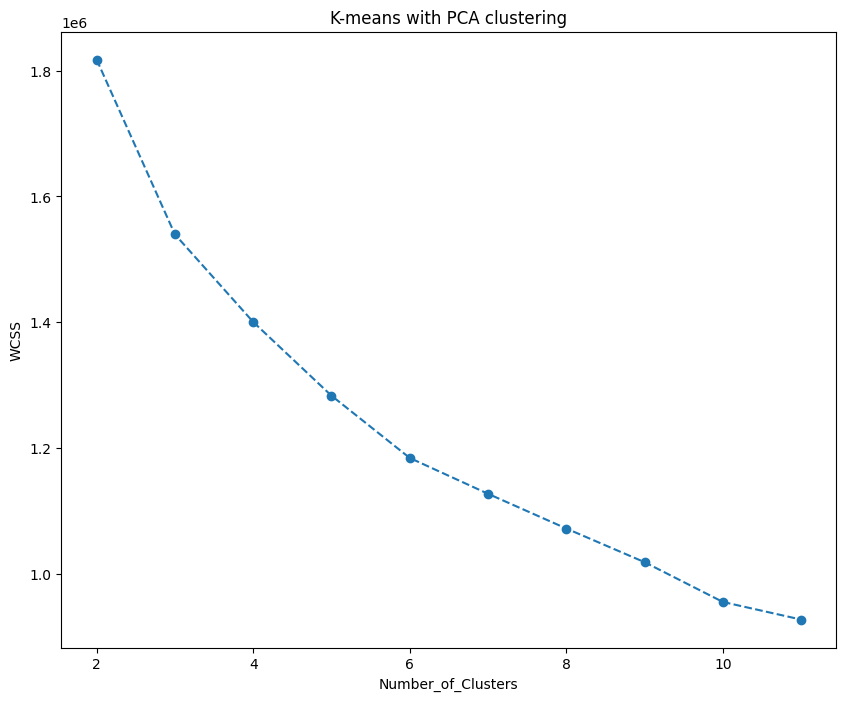

In [69]:
# Clustering using k-means
wccs=[]
for i in range(2,12):
    kmeans_pca = KMeans(n_clusters=i,init="k-means++", random_state=42)
    kmeans_pca.fit(pca_dataset_with_fuel_leak)
    wccs.append(kmeans_pca.inertia_)
    
plt.figure(figsize=(10,8))
plt.plot(range(2,12), wccs, marker="o", linestyle="--")
plt.xlabel("Number_of_Clusters")
plt.ylabel("WCSS")
plt.title("K-means with PCA clustering")
plt.show()

Inertia of k-means clustering with kmeans++:  1400241.614127277
Inertia of k-means clustering with random initialization:  2260919.2472268324


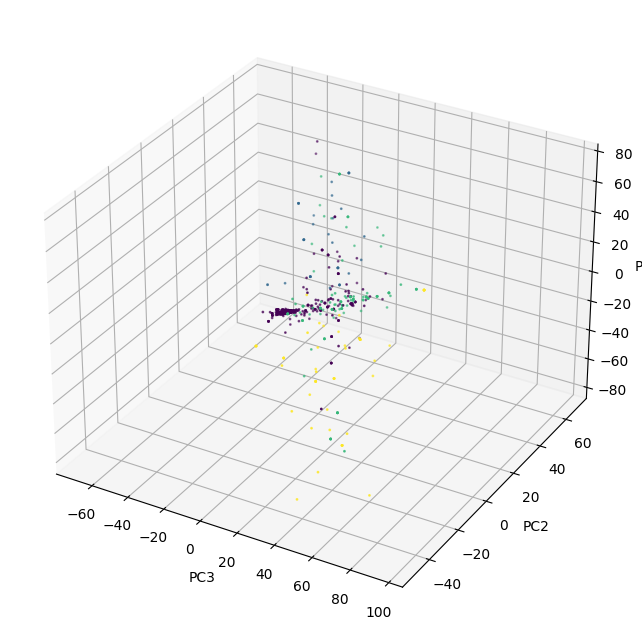

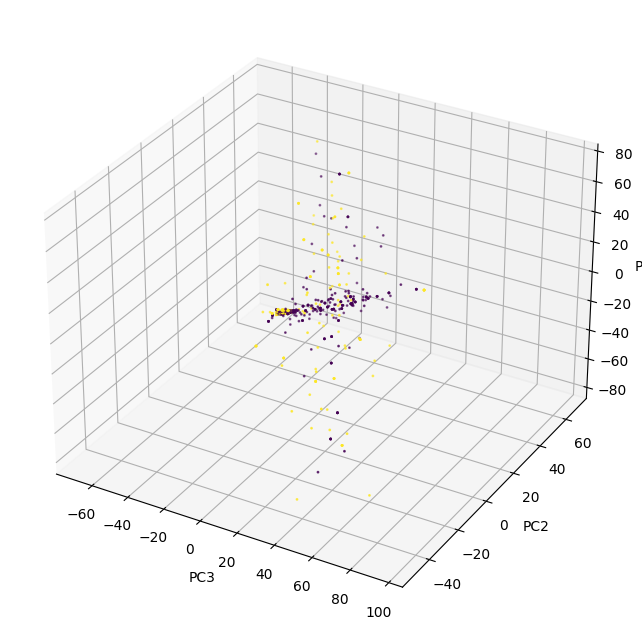

In [70]:
# k-means clustering with kmeans++
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(pca_dataset_with_fuel_leak)

# k-means clustering with random initialization
kmeans_random = KMeans(n_clusters=2, init='random', random_state=42)
kmeans_random.fit(pca_dataset_with_fuel_leak)
 
# predict 
y_pred = kmeans.predict(pca_dataset_with_fuel_leak)
y_pred_random = kmeans_random.predict(pca_dataset_with_fuel_leak)
 
# add cluster labels to dataset
pca_dataset_with_fuel_leak['cluster'] = y_pred
pca_dataset_with_fuel_leak['cluster_random'] = y_pred_random

# inertia
inertia_k_means = kmeans.inertia_
inertion_random = kmeans_random.inertia_
print("Inertia of k-means clustering with kmeans++: ", inertia_k_means)
print("Inertia of k-means clustering with random initialization: ", inertion_random)

 
# silhouette plot
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1') 
ax.scatter(pca_dataset_with_fuel_leak.iloc[:, 1], pca_dataset_with_fuel_leak.iloc[:, 2], pca_dataset_with_fuel_leak.iloc[:, 3], c=y_pred, s=1, cmap='viridis')
plt.show()

# silhouette plot
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC3')
ax.set_ylabel('PC2')
ax.set_zlabel('PC1') 
ax.scatter(pca_dataset_with_fuel_leak.iloc[:, 1], pca_dataset_with_fuel_leak.iloc[:, 2], pca_dataset_with_fuel_leak.iloc[:, 3], c=y_pred_random, s=1, cmap='viridis')
plt.show()
    
 

In [71]:
pca_dataset_with_fuel_leak.groupby('cluster').count()

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
cluster                                                                   
0        112215  112215  112215  112215  112215  112215  112215  112215   
1            41      41      41      41      41      41      41      41   
2           127     127     127     127     127     127     127     127   
3            53      53      53      53      53      53      53      53   

            PC9    PC10    PC11    PC12    PC13    PC14    PC15    PC16  \
cluster                                                                   
0        112215  112215  112215  112215  112215  112215  112215  112215   
1            41      41      41      41      41      41      41      41   
2           127     127     127     127     127     127     127     127   
3            53      53      53      53      53      53      53      53   

           PC17    PC18    PC19    PC20    PC21  cluster_random  
cluster                                                          
0        112215  112215  112215  112215  112215          112215  
1            41      41      41      41      41              41  
2           127     127     127     127     127             127  
3            53      53      53      53      53              53

### Supervised Approach using Auto Enconders

In [72]:
dataset_autoencoder_with_fuel_leak = pd.read_csv("generated_data/merged_dataset_with_fuel_leak.csv")
dataset_autoencoder_with_fuel_leak.shape

(234280, 27)

In [73]:
# add labels to dataset where MSN = MSN_37_LEAK0.5 or MSN_37_LEAK1.0 or MSN_37_LEAK5.0
dataset_autoencoder_with_fuel_leak['label'] = dataset_autoencoder_with_fuel_leak['MSN'].apply(lambda x: 1 if x == 'MSN_37_LEAK0.5' or x == 'MSN_37_LEAK1.0' or x == 'MSN_37_LEAK5.0' else 0)
dataset_autoencoder_with_fuel_leak['label'].value_counts()

0    133609
1    100671
Name: label, dtype: int64

In [74]:
# convert UTC_TIME to datetime
dataset_autoencoder_with_fuel_leak["UTC_TIME"] = pd.to_datetime(dataset_autoencoder_with_fuel_leak['UTC_TIME'])

In [75]:
# seperate datasets by MSN and add to list 
dataset_list = []
for msn in dataset_autoencoder_with_fuel_leak['MSN'].unique():
    dataset_list.append(dataset_autoencoder_with_fuel_leak[dataset_autoencoder_with_fuel_leak['MSN'] == msn])

In [76]:
# resample each dataset to 5 seconds
for i in range(len(dataset_list)):
    dataset_list[i] = dataset_list[i].set_index('UTC_TIME').resample('5S').mean().dropna()
    

In [77]:
# concat all datasets into one
dataset_autoencoder_with_fuel_leak = pd.concat(dataset_list)
 
# save dataset to csv
dataset_autoencoder_with_fuel_leak.to_csv("generated_data/dataset_autoencoder_with_fuel_leak_resampled.csv", index=False)

## Testing


In [78]:
# in df_test plot TOTAL_FUEL_USED for each flight
for flight in df_test['FLIGHT'].unique():
    # count number of rows for each flight
    if df_test[df_test['FLIGHT'] == flight].shape[0] > 1:
        # plot TOTAL_FUEL_USED for each flight x = UTC_TIME, y = TOTAL_FUEL_USED only plot if FLIGHT_PHASE_COUNT == 8
        if df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].iloc[0] == 2:
            plt.plot(df_test[df_test['FLIGHT'] == flight]['UTC_TIME'], df_test[df_test['FLIGHT'] == flight]['VALUE_FOB_DIFF'])
            plt.show()

NameError: name 'df_test' is not defined

In [ ]:
# for each flight and each flightphase calculate the std of VALUE_FOB_DIFF 

results = []
for flight in df_test['FLIGHT'].unique():
    result = {}
    for flightphase in df_test[df_test['FLIGHT'] == flight]['FLIGHT_PHASE_COUNT'].unique():
        result['FLIGHT'] = flight
        result['FLIGHT_PHASE'] = flightphase
        result['VALUE_FOB_DIFF_std'] = df_test[(df_test['FLIGHT'] == flight) & (df_test['FLIGHT_PHASE_COUNT'] == flightphase)]['VALUE_FOB_DIFF'].std()
        results.append(result)
        
results_df = pd.DataFrame(results)

pd.pivot_table(results_df, values='VALUE_FOB_DIFF_std', index=['FLIGHT'], columns=['FLIGHT_PHASE'], aggfunc=np.sum,  fill_value=0).sort_values(by=[11], ascending=False)


In [ ]:
# plot for dataset 0 for column LEAK_DETECTION_LEAK_FLOW
datasets[0].plot.scatter(x='UTC_TIME', y='LEAK_DETECTION_LEAK_FLOW')

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Extract numeric part from 'Flight' column
datasets[0]['Flight_number'] = datasets[0]['Flight'].str.extract('(\d+)').astype(int)

# Sort DataFrame by 'Flight_number'
sorted_df = datasets[0].sort_values(by='Flight_number')

fig = go.Figure()

# boxplot for sorted DataFrame for column VALUE_FOB.
fig.add_trace(go.Box(
    x= sorted_df['Flight'], 
    y= sorted_df['VALUE_FOB'], 
    name= 'VALUE_FOB',
    line=dict(color='green'),  # change boxplot color to green
    marker=dict(color='green') # change marker color to green
))

# Calculate mean for each flight in the sorted DataFrame
mean_fob = sorted_df.groupby('Flight')['VALUE_FOB'].mean()

# Add a scatter plot for the mean values
fig.add_trace(go.Scatter(
    x=mean_fob.index, 
    y=mean_fob.values, 
    mode='lines', 
    name='Mean',
    line=dict(color='purple')  # set line color to purple
))

fig.update_layout(
    title_text="Boxplot for sorted dataset for column VALUE_FOB", 
    xaxis_title="Flight", 
    yaxis_title="VALUE_FOB",
    plot_bgcolor='black',  # set plot background color to black
    paper_bgcolor='black',  # set paper background color to black
    font=dict(color='white'),  # set font color to white
    autosize=False,
    width=1000,
    height=600
)

fig.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cat_features02 = [col for col in datasets[0] if datasets[0][col].dtypes.name == 'bool']
features02 = [col for col in datasets[0] if col not in cat_features02 if 'STATUS' not in col if 'MODE' not in col if col not in ["day", "month", "time", "year", "SELECTED_GADIR_ALTITUDE_VALUE", "VALUE_FUEL_VOL_LST", "VALUE_FUEL_VOL_RST", "FLIGHT_PHASE_COUNT", "APU_FUEL_FLOW_REQUEST_SIGNAL_1"]]

fig, ax = plt.subplots(figsize=(30,25)) 
sns.heatmap(msn02_smooth[features02].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right')


In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

def plot_datasets(dataset):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for date in dataset['DATE'].unique():
        for flight in dataset['MSN'].unique():
            # Create a subplot
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig 
            fig.update_layout(height=1400, width=1400)

            # Loop over each column
            for i, col in enumerate(fuel_qty_cols):
                # save the dataset for the current date and flight
                dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight)]
                # Add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # Update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

            # Show the plot
            #fig.show()
            
            # save the plot as png
            fig.write_image("plots2/" + str(date) +"-" + str(flight) + ".png")
     
            
#plot_datasets(datasets[1])

#for i in range(len(datasets)):
 #   if i > 1:
  #      plot_datasets(datasets[i])

In [ ]:
def plot_dataset_for_date(dataset, date, flight_phase):
    # List of columns to plot for VALUE_FUEL_QTY_CT;VALUE_FUEL_QTY_FT1;VALUE_FUEL_QTY_FT2;VALUE_FUEL_QTY_FT3;VALUE_FUEL_QTY_FT4;VALUE_FUEL_QTY_LXT;VALUE_FUEL_QTY_RXT
    fuel_qty_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']

    # Loop over every unique date
    for flight in dataset['MSN'].unique():
        # Create a subplot
        fig = sp.make_subplots(rows=3, cols=3)

        # size of fig 
        fig.update_layout(height=1000, width=1200)

        # Loop over each column
        for i, col in enumerate(fuel_qty_cols):
            # save the dataset for the current date and flight
            dataset_tmp = dataset[(dataset['DATE'] == date) & (dataset['MSN'] == flight) & (dataset['FLIGHT_PHASE_COUNT'] == flight_phase)]
            # Add scatter plot to subplot

            fig.add_trace(
                go.Scatter(x=dataset_tmp['UTC_TIME'], 
                        y=dataset_tmp[col], 
                        mode='markers',
                        name=col),
                row=i//3 + 1, 
                col=i%3 + 1
            )

            # Update xaxis and yaxis titles
            fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
            fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)

    # Show the plot
    fig.show()

In [ ]:
plot_dataset_for_date(datasets[1], datetime.date(2015, 3, 7), 8.0)

In [ ]:
datasets[6][['DATE', 'MSN', 'FLIGHT_PHASE_COUNT']][datasets[6]['FLIGHT_PHASE_COUNT'] == 8.0]

In [ ]:
# function to add leakage data to the dataset
def add_leakage_data(dataset, leakage_qty):
    # substract leakage_qty from VALUE_FOB col
    dataset['VALUE_FOB'] = dataset['VALUE_FOB'] - (leakage_qty / 60)
    
    # add column FUEL_USED_BY_FOB to dataset
    # first column is 0 because we don't know the fuel used at the start of the flight
    # every next row is the row + difference between the current and previous row in VALUE_FOB
    dataset['FUEL_USED_BY_FOB'] = 0
    for i in range(1, dataset.shape[0]):
        dataset['FUEL_USED_BY_FOB'].iloc[i] = dataset['FUEL_USED_BY_FOB'].iloc[i-1] + (dataset['VALUE_FOB'].iloc[i] - dataset['VALUE_FOB'].iloc[i-1])
    
        

In [ ]:
add_leakage_data(datasets[8], 0.5)
add_leakage_data(datasets[9], 1.0)
add_leakage_data(datasets[10], 5.0)

In [ ]:
def relative_fuel_used(dataset):
    nulls = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0]["FUEL_USED_1"].isnull().sum()
    shape_0 = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8.0].shape[0]
    
    print(f"dataset_{1}", nulls / shape_0)
    
for dataset in datasets:
    relative_fuel_used(dataset)

In [ ]:
# plot for dataset 6 for 2016-07-27, flightphase 8
# plot columns VALUE_FOB and FUEL_USED_BY_FOB
dataste_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8.0) & (datasets[0]['DATE'] == datetime.date(2011, 3, 9))]

dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB'] - (5.0)

dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["FUEL_USED_1"] + dataste_tmp["FUEL_USED_2"] + dataste_tmp["FUEL_USED_3"] + dataste_tmp["FUEL_USED_4"]
dataste_tmp["TOTAL_CONSUMPTION"] = dataste_tmp["TOTAL_CONSUMPTION"] - dataste_tmp["TOTAL_CONSUMPTION"].iloc[0]

# invert the values of VALUE_FOB_LEAKAGE so that the highest value is 0
dataste_tmp['VALUE_FOB_LEAKAGE'] = dataste_tmp['VALUE_FOB_LEAKAGE'].max() - dataste_tmp['VALUE_FOB_LEAKAGE'] + 5.0

dataste_tmp['VALUE_FOB'] = dataste_tmp['VALUE_FOB'].max() - dataste_tmp['VALUE_FOB']


fig = go.Figure()

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
            y=dataste_tmp['TOTAL_CONSUMPTION'],
            name='TOTAL_CONSUMPTION')
)


fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB_LEAKAGE'],
                name='VALUE_FOB_LEAKAGE')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['VALUE_FOB'],
                name='VALUE_FOB')
)

fig.add_trace(
    go.Scatter(x=dataste_tmp['UTC_TIME'],
                y=dataste_tmp['FW_GEO_ALTITUDE'],
                name='FW_GEO_ALTITUDE')
)

fig.show()

In [ ]:
# introduce new columns for each dataset [CT_DIFF, LXT_DIFF, RXT_DIFF, FT1_DIFF, FT2_DIFF, FT3_DIFF, FT4_DIFF]
# value represents the difference between the current and the previous value
for dataset in datasets:
    dataset['CT_DIFF'] = dataset['VALUE_FUEL_QTY_CT'].diff()
    dataset['LXT_DIFF'] = dataset['VALUE_FUEL_QTY_LXT'].diff()
    dataset['RXT_DIFF'] = dataset['VALUE_FUEL_QTY_RXT'].diff()
    dataset['FT1_DIFF'] = dataset['VALUE_FUEL_QTY_FT1'].diff()
    dataset['FT2_DIFF'] = dataset['VALUE_FUEL_QTY_FT2'].diff()
    dataset['FT3_DIFF'] = dataset['VALUE_FUEL_QTY_FT3'].diff()
    dataset['FT4_DIFF'] = dataset['VALUE_FUEL_QTY_FT4'].diff()  

In [ ]:
datasets[0].head()

In [ ]:
def plot_diff(): 
    #plot diff columns for dataset 0 for each unique date
    for date in datasets[0]['DATE'].unique():
        for flight in datasets[0]['MSN'].unique():
            # create subplot 3 columns and len(datasets[0].unique) rows
            fig = sp.make_subplots(rows=3, cols=3)
            
            # size of fig
            fig.update_layout(height=1000, width=1000)
            
            diff_cols = ['CT_DIFF', 'LXT_DIFF', 'RXT_DIFF', 'FT1_DIFF', 'FT2_DIFF', 'FT3_DIFF', 'FT4_DIFF']
            
            # loop over the diff columns
            for i, col in enumerate(diff_cols):
                # save the dataset for the current date and flight
                dataset_tmp = datasets[0][(datasets[0]['DATE'] == date) & (datasets[0]['MSN'] == flight)]
                # add scatter plot to subplot
                fig.add_trace(
                    go.Scatter(x=dataset_tmp['UTC_TIME'], 
                            y=dataset_tmp[col], 
                            mode='markers',
                            name=col),
                    row=i//3 + 1, 
                    col=i%3 + 1
                )

                # update xaxis and yaxis titles
                fig.update_xaxes(title_text='UTC_TIME', row=i//3 + 1, col=i%3 + 1)
                fig.update_yaxes(title_text=col + " " + str(date), row=i//3 + 1, col=i%3 + 1)
                
            # save fig as png 
            fig.write_image("plots2/diff_plots/" + str(date) + "-" + str(flight) + "_diff.png")

In [ ]:
# ideas
# 1. use lower bound and upper bound to detect outliers
# 2. use the bounds to plot the data and see if there are any outliers
# 3. deep learning auto detection anomaly detection

In [ ]:
# function to generate synthetic data for each dataset including a simulated fuel leak
# using 0,5l, 1L and 5L as the leak size per minute

def generate_synthetic_data(dataset, leak_size):
    # create a copy of the dataset
    synthetic_dataset = dataset.copy()
    
    synthetic_dataset['VALUE_FUEL_QTY_LXT'] = synthetic_dataset['VALUE_FUEL_QTY_LXT'] - (leak_size)
    
    return synthetic_dataset

## Calculate the fuel on board and the Fuel Used

In [ ]:
def calculate_fuel_used(dataset):
    fuel_used_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

    # save the sum of the fuel used columns in a new column
    dataset['FUEL_USED_SUM'] = dataset[fuel_used_cols].sum(axis=1)

    fuel_cols = ['VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4']
    
    dataset['FUEL_COLS_SUM'] = dataset[fuel_cols].sum(axis=1)

    #datasets[0]['FUEL_DIFF_SUM'] = datasets[0]['FUEL_DIFF_SUM'].cumsum()

    # substract from each value in FUEL_COLS_SUM the first value bigger than 1 and get the absoulte value. Do this for each day
    dataset['FUEL_COLS_SUM'] = dataset.groupby(['DATE'])['FUEL_COLS_SUM'].transform(lambda x: x - x[x > 1].iloc[0]).abs()

    return dataset

In [ ]:
import datetime 

datasets[0][datasets[0]['DATE'] == datetime.date(2011, 3, 3)]

In [ ]:
import plotly.graph_objs as go

def plot_fuel_cons_vs_fuel_qty(dataset):
    # plot the fuel_used columns for dataset 0 for 2010-10-26
    fig = go.Figure()
    
    dates_to_find = dataset['DATE'].unique()[:1]

    for date in dates_to_find:
        dataset = dataset[dataset['FLIGHT_PHASE_COUNT'] == 8]
        # plot FUEL_USED_SUM and FUEL_DIFF_SUM
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_USED_SUM'],
                                    name='FUEL_USED_SUM'))
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FUEL_COLS_SUM'],
                                    name='FUEL_COLS_SUM'))
        # add altitude to the plot
        fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                    y=dataset[dataset['DATE'] == date]['FW_GEO_ALTITUDE'],
                                    name='FW_GEO_ALTITUDE'))
        
        fuel_tanks = ['CT', 'LXT', 'RXT', 'FT1', 'FT2', 'FT3', 'FT4']
        # plot the fuel tanks
        for tank in fuel_tanks:
            fig.add_trace(go.Scatter(x=dataset[dataset['DATE'] == date]['UTC_TIME'],
                                        y=dataset[dataset['DATE'] == date]['VALUE_FUEL_QTY_' + tank],
                                        name='VALUE_FUEL_QTY_' + tank))        
        fig.show()

In [ ]:
dataset_with_fuel_leak = generate_synthetic_data(datasets[0], 1800)
dataset_with_fuel_leak = calculate_fuel_used(dataset_with_fuel_leak)
datasets[0] = calculate_fuel_used(datasets[0])

In [ ]:
datasets[0]['FUEL_COLS_SUM'][datasets[0]['FUEL_COLS_SUM'] > 10]

In [ ]:
dataset_with_fuel_leak['FUEL_COLS_SUM'][dataset_with_fuel_leak['FUEL_COLS_SUM'] > 10]

In [ ]:
plot_fuel_cons_vs_fuel_qty(dataset_with_fuel_leak)

In [ ]:
plot_fuel_cons_vs_fuel_qty(datasets[0])

## PCA Analysis

In [ ]:
# import pca 
from sklearn.decomposition import PCA 

pcaInstance = PCA(n_components=2)

dataset_tmp = datasets[0][(datasets[0]['FLIGHT_PHASE_COUNT'] == 8)]

feat_cols = (item for item in dataset_tmp.columns if item.startswith('VALUE_FUEL_QTY'))

dataset_tmp = dataset_tmp[feat_cols].dropna()

print(dataset_tmp.shape)

# fit the pca instance to the dataset
pcaInstance.fit(dataset_tmp)

# transform the dataset
pcaInstance.transform(dataset_tmp)

# get the explained variance ratio
pcaInstance.explained_variance_ratio_

# plot the explained variance ratio 
plt.plot(pcaInstance.explained_variance_ratio_)
plt.show()

# plot the pca components
plt.scatter(pcaInstance.components_[0], pcaInstance.components_[1])
plt.show()
 
 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


In [ ]:
# 3d plot heatmap of the pca components 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
x = pca.components_[0]
y = pca.components_[1]
z = pca.components_[2]
 
ax.scatter(x,y,z, marker="s", c="g", s=40, label='first')
 
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
plt.show()

In [ ]:
for i in range(0, pca.components_.shape[0]):
    for j in range(0, pca.components_.shape[0]):
        plt.scatter(pca.components_[i], pca.components_[j])
        plt.show()


In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_cols = (item for item in datasets[0].columns if item.startswith('VALUE_FUEL_QTY'))

pca = PCA(n_components=10)
X_pca = pca.fit_transform(datasets[0][feat_cols].dropna())

clf = RandomForestClassifier()
clf.fit(X_pca, y)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select numerical columns only
numerical_cols = datasets[0].select_dtypes(include=[np.number]).columns

# Drop missing values
datasets_num = datasets[0][numerical_cols].dropna()

# Standardize the feature matrix
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to your data
pipeline.fit(datasets_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.show()

# show number of components that explain 95% of the variance
print(np.where(cumulative_explained_variance > 0.95)[0][0])



In [ ]:
from sklearn.cluster import KMeans

# let's assume we take first 2 components as they explain the most variance
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(datasets_num)

# convert to dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16'])

# Kmeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)

# visualizing the clusters in 3d
import plotly.graph_objects as go

# Create trace
trace = go.Scatter3d(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    z=pca_transformed[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color=clusters, # set color to an array/list of desired values
        colorscale='Viridis', # choose a colorscale
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    title = '3D Scatter Plot of PCA Components with KMeans Clusters',
    scene = dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()



In [ ]:
# Transform the original data
pca_transformed = pipeline.transform(datasets_num)

# Now you can fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(pca_transformed)

# Append the clusters to the original scaled dataset
datasets_num_clustered = datasets_num.copy()
datasets_num_clustered['Cluster'] = clusters


In [ ]:
# Analyze the clusters
cluster_analysis = datasets_num_clustered.groupby('Cluster').mean()
print(cluster_analysis)


In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)
clusters = dbscan.fit_predict(pca_transformed)
 
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()


In [ ]:
feature_importance = pd.DataFrame(pca.components_, columns=datasets_num.columns)

# Plot the feature importances
fig = plt.figure(figsize=(10, 10))
plt.bar(range(feature_importance.shape[1]), feature_importance.iloc[0])
    
plt.xticks(range(feature_importance.shape[1]), feature_importance.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

print(feature_importance)
 

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_transformed, clusters)
print('Silhouette Score: ', score)

In [ ]:
# Fill NaNs with mean of the column
datasets[0].fillna(datasets[0].mean(), inplace=True)

datasets[0].drop_duplicates(inplace=True)

from scipy import stats
z_scores = stats.zscore(datasets[0][feat_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = datasets[0][filtered_entries]

In [ ]:
import seaborn as sns
corr = new_df.corr()
sns.heatmap(corr)
plt.show()


In [ ]:
sns.pairplot(new_df)
plt.show()
